In [15]:
#!pip install synapseclient

In [16]:
#!pip install synapseutils

In [17]:
# !pip install hyppo    

In [18]:
#  import synapseclient 
#  import synapseutils 
 
#  syn = synapseclient.Synapse() 
#  syn.login('finamintoastcrunch','1Hjldria!') 
#  files = synapseutils.syncFromSynapse(syn, ' syn2825306 ') 

In [19]:
# !pip install -q tensorflow-model-optimization

In [20]:
# !pip install protobuf==3.20.*

# Import Libraries

In [21]:
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import*
from keras.utils.vis_utils import plot_model
import tensorflow.keras.backend as K
# from keras.layers import Input
# from keras.layers import Dense
# from keras.layers import Conv1D
# from keras.layers import Conv1DTranspose
# from keras.layers import Flatten, Reshape

import os
from glob import glob
from tqdm import tqdm
from tensorflow.keras import losses
from sklearn.preprocessing import StandardScaler
import tensorflow_model_optimization as tfmot
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns


from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import warnings

# from interpret import show
# from interpret.blackbox import ShapKernel
import shap
import load_dream4
import GRND_AutoEncoderModels

In [22]:
df = pd.DataFrame

In [23]:
tf.config.list_physical_devices(
    device_type=None
)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [24]:
isEager = tf.executing_eagerly()
isEager

True

In [25]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [27]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Load DS

In [28]:
#load dream4 mult
allMF, allMFGold, _ = load_dream4.load_all_dream4_MultiFactorial()

In [29]:
ds = str(1) #2,3,4,5 There are 5 dream datasets.
dirty_regulations = r'insilico_size100_'+ ds + r'_timeseries.csv'

In [30]:
NUM_PARENTS1 = None #we compute this from the gold standard
NUM_TARGETS = 100
NUM_TIME_STEPS = 21
# NUM_TIME_STEPS = 1
NUM_REPLICATES = 10 

load_dream4.NUM_TARGETS = NUM_TARGETS
load_dream4.NUM_TIME_STEPS = NUM_TIME_STEPS
load_dream4.NUM_REPLICATES = NUM_REPLICATES

GRND_AutoEncoderModels.NUM_TARGETS = NUM_TARGETS
GRND_AutoEncoderModels.NUM_TIME_STEPS = NUM_TIME_STEPS
GRND_AutoEncoderModels.NUM_REPLICATES = NUM_REPLICATES



In [31]:
dataset, allGoldIms, gold = load_dream4.load_all_dream4(num_replicates=10, num_time_steps=21, num_targets=100)


In [32]:
dataset.shape

(5, 10, 21, 100)

In [33]:
#if you set timestep = 1
# allData = np.copy(dataset)
# allData = allData.reshape((210,1,100))
# beanIntensities = allData[0:190]    
# validation = allData[190:]

In [34]:
# if you set time step to 21
beanIntensities = dataset[0][0:8]
validation = dataset[0][8:]
allData = dataset[0]
print(beanIntensities.shape, validation.shape, allData.shape)

(8, 21, 100) (2, 21, 100) (10, 21, 100)


# Load Gold Standard

In [35]:
gold = pd.read_csv("DREAM4_GoldStandard_InSilico_Size100_" + ds + r".csv", header=None)


In [36]:

gold, goldIm = load_dream4.prep_goldStandard(gold, num_targets=100)
goldIm = goldIm.astype(np.float32)

In [37]:
non_zero = np.nonzero(goldIm) #non-zero hold all the true connections
#non_zero = np.array(np.unravel_index(non_zero, shape = (NUM_PARENTS1, NUM_TARGETS)))

# RGM and RGM+

In [38]:
# regulator_gene_matrix = goldIm.astype(np.float32) #I set rgm to gold because I didnt not want ot re-write everything
# superParent1 = regulator_gene_matrix.copy()
# ones = np.ones((NUM_TARGETS))
# parent_idx1 = []
# not_parentIndex = []
# for i in range(len(regulator_gene_matrix)):
#     if (np.isin(regulator_gene_matrix[i], [1])).any():
#         #print(i)
#         superParent1[i] = ones 
#         parent_idx1.append(i)
#     else:
#         not_parentIndex.append(i)

# parent_idx1 = np.array(parent_idx1)
# parent_idx1 = tf.convert_to_tensor(parent_idx1)
# parent_idx = parent_idx1.numpy()
# not_parentIndex = np.array(not_parentIndex)
# not_parentIndex = tf.convert_to_tensor(not_parentIndex)
# print("shape of parent index", parent_idx1.shape)

# GRND_AutoEncoderModels.parent_idx1 = parent_idx1

allSuperParents, all_parent_idx = load_dream4.getSuperParents(allGoldIms)

#the code below runs the experiment without any known regulators
regulator_gene_matrix = np.ones((NUM_TARGETS,NUM_TARGETS), dtype='float32') #we keep this because we want to not mess with the weight init
# parent_idx1 = np.arange(stop=NUM_PARENTS1)
# parent_idx1 = tf.convert_to_tensor(parent_idx1)
# parent_idx = parent_idx1.numpy()

In [39]:
parent_idx1 = all_parent_idx[0]

In [40]:
superParent1 = allSuperParents[0]

In [41]:
NUM_PARENTS1 = parent_idx1.shape[0]


In [42]:
parent_idx1

array([ 0,  4,  9, 14, 22, 24, 25, 35, 36, 37, 39, 41, 42, 43, 44, 45, 53,
       54, 56, 61, 62, 63, 64, 65, 66, 68, 71, 72, 74, 81, 82, 84, 86, 89,
       90, 91, 92, 95, 97, 98, 99])

<AxesSubplot:>

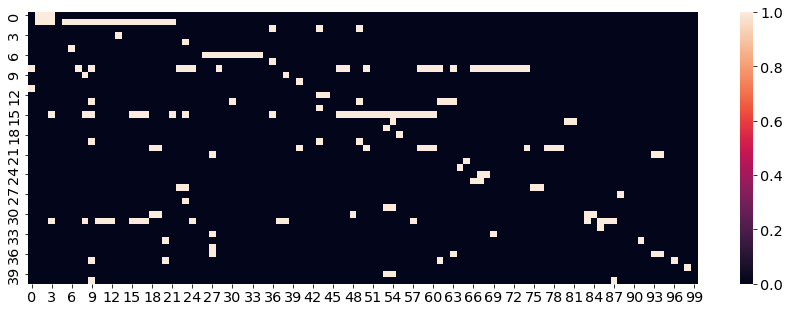

In [43]:
sns.heatmap(goldIm[parent_idx1])

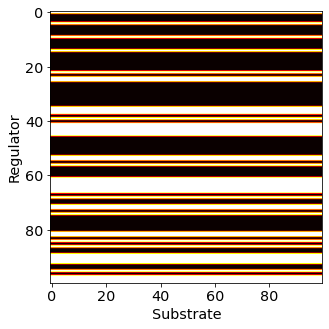

In [44]:
plt.imshow(superParent1, cmap='hot');
plt.xlabel("Substrate");
plt.ylabel("Regulator");

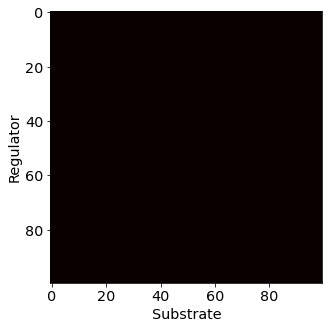

In [45]:
plt.imshow(regulator_gene_matrix, cmap='hot');
plt.xlabel("Substrate");
plt.ylabel("Regulator");

# Try DSP

In [46]:

def evaluate_masks(gold_im, rgm, printOut=True):
    """
    Function to calculate the true positive rate (TPR), true negative rate (TNR),
    false positive rate (FPR), and false negative rate (FNR) for the provided image masks.

    The function uses the gold_im (ground truth) and rgm (predicted values) as inputs.
    The rgm values are confidence values between 0 and 1.

    Args:
        gold_im (numpy.ndarray): A 2D array representing the ground truth mask, composed of 0s and 1s.
        rgm (numpy.ndarray): A 2D array representing the predicted mask, with elements between 0 and 1 (inclusive).

    Returns:
        float: True positive rate (TPR)
        float: True negative rate (TNR)
        float: False positive rate (FPR)
        float: False negative rate (FNR)
    """
    # Flatten the arrays
    gold_im = np.array(gold_im).flatten()
    rgm = np.abs(np.array(rgm)).flatten()

    # Calculate the threshold for the top 'tk' most confident elements
    tk = np.sum(gold_im)
    threshold = np.sort(rgm)[-int(tk)]

    # Predicted labels
    predicted = np.zeros(rgm.shape)
    predicted[rgm >= threshold] = 1

    # Compute the true positives, true negatives, false positives, false negatives
    TP = np.sum((predicted == 1) & (gold_im == 1))
    TN = np.sum((predicted == 0) & (gold_im == 0))
    FP = np.sum((predicted == 1) & (gold_im == 0))
    FN = np.sum((predicted == 0) & (gold_im == 1))

    # Compute the rates
    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    FPR = FP / (FP + TN)
    FNR = FN / (FN + TP)

    if printOut == True:
        print("TPR: ", TPR)
        print("TNR: ", TNR)
        print("FPR: ", FPR)
        print("FNR: ", FNR)

    return TPR, TNR, FPR, FNR


In [47]:
def get_top_mask(gold_im, rgm):
    """
    Function to get the binary mask based on the 'tk' most confident elements in a provided 2D array.

    The function uses the gold_im (ground truth) and rgm (predicted values) as inputs.
    The rgm values are confidence values between 0 and 1, with absolute values taken.

    Args:
        gold_im (numpy.ndarray): A 2D array representing the ground truth mask, composed of 0s and 1s.
        rgm (numpy.ndarray): A 2D array representing the predicted mask, with elements between 0 and 1 (inclusive).

    Returns:
        numpy.ndarray: A binary mask based on the 'tk' most confident elements in the rgm array.
    """

    # Flatten the arrays
    gold_im = np.array(gold_im).flatten()
    rgm = np.abs(np.array(rgm)).flatten()

    # Calculate the threshold for the top 'tk' most confident elements
    tk = np.sum(gold_im)
    threshold = np.sort(rgm)[-int(tk)]

    # Predicted labels
    predicted = np.zeros(rgm.shape)
    predicted[rgm >= threshold] = 1

    return predicted.reshape(NUM_TARGETS, NUM_TARGETS).astype(np.float32)

In [48]:
def top_k_correlations(avg_corr, top_k):
    # Create a mask of zeros with the same shape as avg_corr
    mask = np.zeros_like(avg_corr)

    # We flatten the array for easier manipulation
    flat_corr = avg_corr.flatten()

    # We find the threshold to be in the top_k greatest values
    threshold = np.partition(flat_corr, -top_k)[-top_k]

    # We fill the mask with ones where the correlation is greater than or equal to the threshold
    mask[avg_corr >= threshold] = 1

    return mask

In [49]:
def pairwise_cross_correlation(arr):
    num_samples, time_steps, num_features = arr.shape

    avg_corr = np.zeros((num_features, num_features))
    avg_delay = np.zeros((num_features, num_features), dtype=np.float32)

    for i in range(num_features):
        for j in range(i + 1, num_features):
            corr = np.zeros(num_samples)
            delay = np.zeros(num_samples, dtype=int)
            for k in range(num_samples):
                cross_corr = np.correlate(arr[k, :, i], arr[k, :, j], 'full')
                corr[k] = np.abs(cross_corr).max()
                delay[k] = np.argmax(cross_corr) - (time_steps - 1)

            avg_corr[i, j] = avg_corr[j, i] = corr.mean()
            avg_delay[i, j] = avg_delay[j, i] = delay.mean()

   # avg_corr = avg_corr - np.eye(len(avg_corr)) not needed
    return avg_corr, avg_delay

In [50]:
corr, delay = pairwise_cross_correlation(allData)

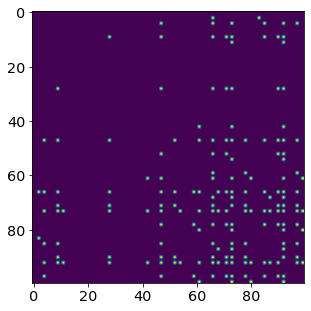

In [51]:
plt.imshow(top_k_correlations(corr, top_k=int(goldIm.sum())))

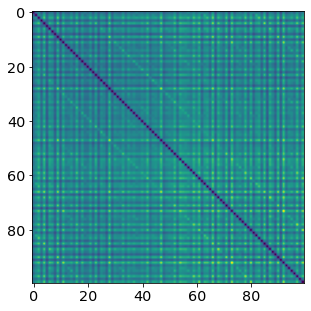

In [52]:
plt.imshow(corr)

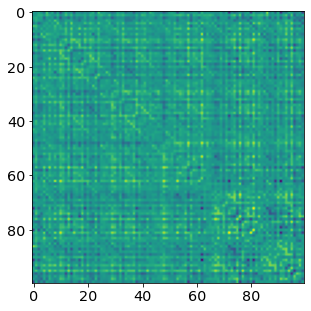

In [53]:
plt.imshow(delay);

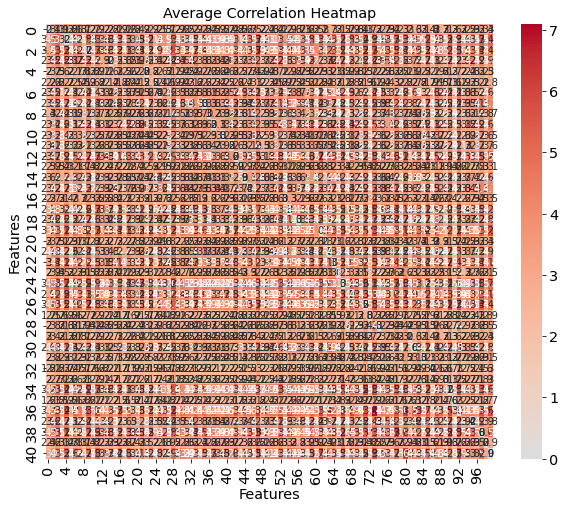

In [54]:
# For correlation
plt.figure(figsize=(10, 8))
sns.heatmap(corr[parent_idx1], annot=True, cmap='coolwarm', center=0)
plt.title("Average Correlation Heatmap")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()


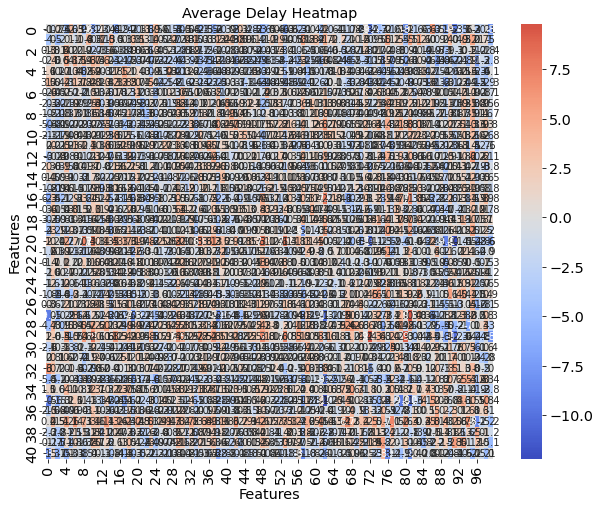

In [55]:
# For delay
plt.figure(figsize=(10, 8))
sns.heatmap(delay[parent_idx1], annot=True, cmap='coolwarm', center=0)
plt.title("Average Delay Heatmap")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()

# Custom Loss

In [56]:
import GRND_AutoEncoderModels


In [57]:
ignore_noParent_MSE = GRND_AutoEncoderModels.get_ignore_noParent_MSE(parent_idx1)

In [58]:
parent_idx1

array([ 0,  4,  9, 14, 22, 24, 25, 35, 36, 37, 39, 41, 42, 43, 44, 45, 53,
       54, 56, 61, 62, 63, 64, 65, 66, 68, 71, 72, 74, 81, 82, 84, 86, 89,
       90, 91, 92, 95, 97, 98, 99])

# Super Parent AutoEncoder

In [59]:
#TODO: try 1 time step at at time. 

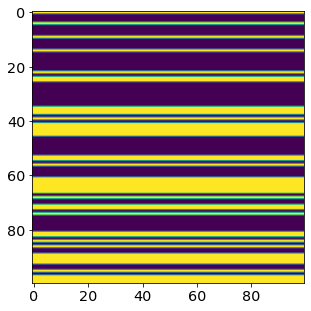

In [60]:
plt.imshow(superParent1)

In [61]:
looseParent = GRND_AutoEncoderModels.modelSuperParent_AutoEncoder(superParent1, superParent1, 100, 21, NUM_PARENTS1, sparsity=0.9824)
# looseParent = GRND_AutoEncoderModels.modelSuperParent_AutoEncoder(goldIm.astype(np.float32), goldIm.astype(np.float32), NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, num_hidden_units=NUM_PARENTS1)
looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
o = looseParent.fit(beanIntensities, beanIntensities, epochs=300, verbose = True,  
                    validation_data=(validation, validation), callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()])
# print(o.history['loss'][-1]) #the final loss 

Epoch 1/300
1/1 [==============================] - 6s 6s/step - loss: 0.2202 - val_loss: 0.1966
Epoch 2/300
1/1 [==============================] - 0s 33ms/step - loss: 0.2122 - val_loss: 0.1812
Epoch 3/300
1/1 [==============================] - 0s 31ms/step - loss: 0.1945 - val_loss: 0.1549
Epoch 4/300
1/1 [==============================] - 0s 30ms/step - loss: 0.1642 - val_loss: 0.1214
Epoch 5/300
1/1 [==============================] - 0s 30ms/step - loss: 0.1256 - val_loss: 0.1048
Epoch 6/300
1/1 [==============================] - 0s 30ms/step - loss: 0.1048 - val_loss: 0.1089
Epoch 7/300
1/1 [==============================] - 0s 32ms/step - loss: 0.1076 - val_loss: 0.0827
Epoch 8/300
1/1 [==============================] - 0s 29ms/step - loss: 0.0794 - val_loss: 0.0647
Epoch 9/300
1/1 [==============================] - 0s 30ms/step - loss: 0.0606 - val_loss: 0.0602
Epoch 10/300
1/1 [==============================] - 0s 32ms/step - loss: 0.0562 - val_loss: 0.0574
Epoch 11/300
1/1 [===

In [62]:
looseParent.evaluate(validation, validation)

1/1 [==============================] - 0s 23ms/step - loss: 0.0179


0.017859546467661858

In [63]:
looseParent.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21, 100)]         0         
                                                                 
 prune_low_magnitude_encoder  (None, 21, 100)          20002     
 _linear_super_parent (Prune                                     
 LowMagnitude)                                                   
                                                                 
 conv1d (Conv1D)             (None, 21, 100)           30100     
                                                                 
 flatten (Flatten)           (None, 2100)              0         
                                                                 
 dense (Dense)               (None, 41)                86141     
                                                                 
 dense_1 (Dense)             (None, 134)               5628  

In [64]:
m = looseParent.get_layer(index=1).get_weights()

In [65]:
evaluate_masks(goldIm, m)

TPR:  0.056818181818181816
TNR:  0.9831026058631922
FPR:  0.016897394136807818
FNR:  0.9431818181818182


(0.056818181818181816,
 0.9831026058631922,
 0.016897394136807818,
 0.9431818181818182)

In [66]:
loose_mask = get_top_mask(goldIm, m)

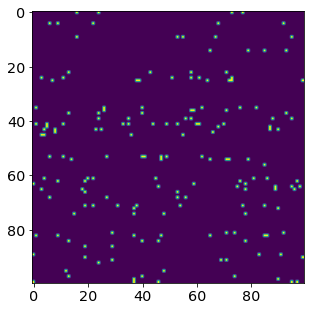

In [67]:
plt.imshow(loose_mask)

In [68]:
looseParent2 = GRND_AutoEncoderModels.modelSuperParent_AutoEncoder(loose_mask, loose_mask, NUM_TARGETS, NUM_TIME_STEPS, NUM_PARENTS1)
# looseParent = GRND_AutoEncoderModels.modelSuperParent_AutoEncoder(goldIm.astype(np.float32), goldIm.astype(np.float32), NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, num_hidden_units=NUM_PARENTS1)
looseParent2.compile(optimizer='adam', loss=ignore_noParent_MSE)
o = looseParent2.fit(beanIntensities, beanIntensities, epochs=300, verbose = True,  
                    validation_data=(validation, validation), callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()])

Epoch 1/300
1/1 [==============================] - 2s 2s/step - loss: 0.2210 - val_loss: 0.2041
Epoch 2/300
1/1 [==============================] - 0s 38ms/step - loss: 0.2208 - val_loss: 0.2039
Epoch 3/300
1/1 [==============================] - 0s 39ms/step - loss: 0.2206 - val_loss: 0.2035
Epoch 4/300
1/1 [==============================] - 0s 43ms/step - loss: 0.2202 - val_loss: 0.2029
Epoch 5/300
1/1 [==============================] - 0s 43ms/step - loss: 0.2195 - val_loss: 0.2018
Epoch 6/300
1/1 [==============================] - 0s 42ms/step - loss: 0.2183 - val_loss: 0.2002
Epoch 7/300
1/1 [==============================] - 0s 38ms/step - loss: 0.2164 - val_loss: 0.1977
Epoch 8/300
1/1 [==============================] - 0s 35ms/step - loss: 0.2136 - val_loss: 0.1941
Epoch 9/300
1/1 [==============================] - 0s 38ms/step - loss: 0.2096 - val_loss: 0.1889
Epoch 10/300
1/1 [==============================] - 0s 38ms/step - loss: 0.2038 - val_loss: 0.1819
Epoch 11/300
1/1 [===

# DenseNetAutoEncoder

In [69]:
#dense = modelDense2(superParent1, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, num_hidden_units=NUM_PARENTS1)
# dense = GRND_AutoEncoderModels.modelDense_AutoEncoder(goldIm.astype(np.float32), goldIm.astype(np.float32), NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, num_hidden_units=NUM_PARENTS1)
# l = tf.keras.losses.MeanSquaredError()
dense = GRND_AutoEncoderModels.modelDense_AutoEncoder(superParent1, superParent1, NUM_TARGETS, NUM_TIME_STEPS, num_hidden_units=NUM_PARENTS1, sparsity=0.9824)
dense.compile(optimizer='adam', loss= ignore_noParent_MSE)
dense.fit(beanIntensities, beanIntensities, epochs=300,  verbose=True, validation_data=(validation, validation),
          callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()])

Epoch 1/300
1/1 [==============================] - 2s 2s/step - loss: 0.2208 - val_loss: 0.1962
Epoch 2/300
1/1 [==============================] - 0s 32ms/step - loss: 0.2119 - val_loss: 0.1741
Epoch 3/300
1/1 [==============================] - 0s 34ms/step - loss: 0.1883 - val_loss: 0.1510
Epoch 4/300
1/1 [==============================] - 0s 30ms/step - loss: 0.1634 - val_loss: 0.1273
Epoch 5/300
1/1 [==============================] - 0s 29ms/step - loss: 0.1376 - val_loss: 0.1035
Epoch 6/300
1/1 [==============================] - 0s 32ms/step - loss: 0.1114 - val_loss: 0.0816
Epoch 7/300
1/1 [==============================] - 0s 33ms/step - loss: 0.0867 - val_loss: 0.0636
Epoch 8/300
1/1 [==============================] - 0s 32ms/step - loss: 0.0656 - val_loss: 0.0515
Epoch 9/300
1/1 [==============================] - 0s 34ms/step - loss: 0.0503 - val_loss: 0.0462
Epoch 10/300
1/1 [==============================] - 0s 31ms/step - loss: 0.0419 - val_loss: 0.0460
Epoch 11/300
1/1 [===

In [70]:
dense.summary() #0.0241 val_loss: 0.1261 #gold val_loss: 0.0607

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 21, 100)]    0           []                               
                                                                                                  
 prune_low_magnitude_dae__encod  (None, 21, 100)     20002       ['input_3[0][0]']                
 er_mask (PruneLowMagnitude)                                                                      
                                                                                                  
 conv1d_2 (Conv1D)              (None, 21, 100)      210100      ['prune_low_magnitude_dae__encode
                                                                 r_mask[0][0]']                   
                                                                                            

In [71]:
dm = dense.get_layer(index=1).get_weights()


In [72]:
evaluate_masks(goldIm, dm)

TPR:  0.045454545454545456
TNR:  0.9828990228013029
FPR:  0.01710097719869707
FNR:  0.9545454545454546


(0.045454545454545456,
 0.9828990228013029,
 0.01710097719869707,
 0.9545454545454546)

In [73]:
dense_mask = get_top_mask(goldIm,dm)


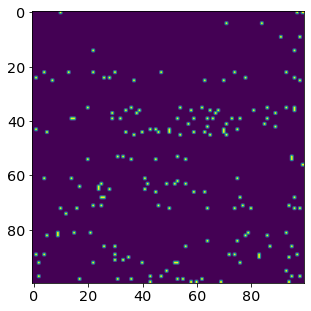

In [74]:
plt.imshow(dense_mask)

In [75]:
NUM_PARENTS1

41

In [76]:
dense2 = GRND_AutoEncoderModels.modelDense_AutoEncoder(dense_mask, dense_mask, NUM_TARGETS, NUM_TIME_STEPS, num_hidden_units=NUM_PARENTS1, sparsity=0.0)
dense2.compile(optimizer='adam', loss= ignore_noParent_MSE)
dense2.fit(beanIntensities, beanIntensities, epochs=300,  verbose=True, validation_data=(validation, validation),
          callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()])

Epoch 1/300
1/1 [==============================] - 2s 2s/step - loss: 0.2210 - val_loss: 0.2040
Epoch 2/300
1/1 [==============================] - 0s 51ms/step - loss: 0.2207 - val_loss: 0.2035
Epoch 3/300
1/1 [==============================] - 0s 46ms/step - loss: 0.2202 - val_loss: 0.2025
Epoch 4/300
1/1 [==============================] - 0s 52ms/step - loss: 0.2190 - val_loss: 0.2005
Epoch 5/300
1/1 [==============================] - 0s 46ms/step - loss: 0.2169 - val_loss: 0.1974
Epoch 6/300
1/1 [==============================] - 0s 42ms/step - loss: 0.2134 - val_loss: 0.1929
Epoch 7/300
1/1 [==============================] - 0s 37ms/step - loss: 0.2086 - val_loss: 0.1873
Epoch 8/300
1/1 [==============================] - 0s 45ms/step - loss: 0.2025 - val_loss: 0.1810
Epoch 9/300
1/1 [==============================] - 0s 44ms/step - loss: 0.1958 - val_loss: 0.1746
Epoch 10/300
1/1 [==============================] - 0s 34ms/step - loss: 0.1891 - val_loss: 0.1684
Epoch 11/300
1/1 [===

# Dense LSTM

In [77]:
denseLSTM = GRND_AutoEncoderModels.modelDense_AutoEncoder(superParent1, superParent1, NUM_TARGETS, NUM_TIME_STEPS, num_hidden_units=NUM_PARENTS1, sparsity=0.9824, useRNN=True)
denseLSTM.compile(optimizer='adam', loss= ignore_noParent_MSE)
denseLSTM.fit(beanIntensities, beanIntensities, epochs=300,  verbose=True, validation_data=(validation, validation),
          callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()])

Epoch 1/300
1/1 [==============================] - 3s 3s/step - loss: 0.2211 - val_loss: 0.1961
Epoch 2/300
1/1 [==============================] - 0s 44ms/step - loss: 0.2117 - val_loss: 0.1774
Epoch 3/300
1/1 [==============================] - 0s 46ms/step - loss: 0.1912 - val_loss: 0.1501
Epoch 4/300
1/1 [==============================] - 0s 51ms/step - loss: 0.1618 - val_loss: 0.1199
Epoch 5/300
1/1 [==============================] - 0s 44ms/step - loss: 0.1292 - val_loss: 0.0919
Epoch 6/300
1/1 [==============================] - 0s 51ms/step - loss: 0.0987 - val_loss: 0.0698
Epoch 7/300
1/1 [==============================] - 0s 45ms/step - loss: 0.0737 - val_loss: 0.0557
Epoch 8/300
1/1 [==============================] - 0s 45ms/step - loss: 0.0565 - val_loss: 0.0499
Epoch 9/300
1/1 [==============================] - 0s 46ms/step - loss: 0.0474 - val_loss: 0.0494
Epoch 10/300
1/1 [==============================] - 0s 46ms/step - loss: 0.0439 - val_loss: 0.0501
Epoch 11/300
1/1 [===

In [78]:
denseLSTM.summary() 

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 21, 100)]    0           []                               
                                                                                                  
 prune_low_magnitude_dae__encod  (None, 21, 100)     20002       ['input_5[0][0]']                
 er_mask_2 (PruneLowMagnitude)                                                                    
                                                                                                  
 lstm (LSTM)                    (None, 41)           23288       ['prune_low_magnitude_dae__encode
                                                                 r_mask_2[0][0]']                 
                                                                                            

In [79]:
lmask = denseLSTM.get_layer(index=1).get_weights()

In [80]:
evaluate_masks(goldIm,lmask)

TPR:  0.07386363636363637
TNR:  0.9834079804560261
FPR:  0.016592019543973942
FNR:  0.9261363636363636


(0.07386363636363637,
 0.9834079804560261,
 0.016592019543973942,
 0.9261363636363636)

In [81]:
lstmMask = get_top_mask(goldIm, lmask)

In [82]:
denseLSTM2 = GRND_AutoEncoderModels.modelDense_AutoEncoder(lstmMask, lstmMask, NUM_TARGETS, NUM_TIME_STEPS, num_hidden_units=NUM_PARENTS1, sparsity=0.0, useRNN=True)
denseLSTM2.compile(optimizer='adam', loss= ignore_noParent_MSE)
denseLSTM2.fit(beanIntensities, beanIntensities, epochs=300,  verbose=True, validation_data=(validation, validation),
          callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()])

Epoch 1/300
1/1 [==============================] - 3s 3s/step - loss: 0.2210 - val_loss: 0.2040
Epoch 2/300
1/1 [==============================] - 0s 47ms/step - loss: 0.2207 - val_loss: 0.2037
Epoch 3/300
1/1 [==============================] - 0s 51ms/step - loss: 0.2203 - val_loss: 0.2030
Epoch 4/300
1/1 [==============================] - 0s 51ms/step - loss: 0.2196 - val_loss: 0.2020
Epoch 5/300
1/1 [==============================] - 0s 45ms/step - loss: 0.2185 - val_loss: 0.2006
Epoch 6/300
1/1 [==============================] - 0s 50ms/step - loss: 0.2168 - val_loss: 0.1985
Epoch 7/300
1/1 [==============================] - 0s 39ms/step - loss: 0.2145 - val_loss: 0.1958
Epoch 8/300
1/1 [==============================] - 0s 43ms/step - loss: 0.2114 - val_loss: 0.1922
Epoch 9/300
1/1 [==============================] - 0s 44ms/step - loss: 0.2074 - val_loss: 0.1879
Epoch 10/300
1/1 [==============================] - 0s 45ms/step - loss: 0.2026 - val_loss: 0.1827
Epoch 11/300
1/1 [===

# Reconstruction

In [83]:
o = dense.predict(validation)
o.shape

1/1 [==============================] - 0s 103ms/step


(2, 21, 100)

In [84]:
r = pd.DataFrame(o[0].reshape(NUM_TIME_STEPS,NUM_TARGETS))
v = pd.DataFrame(validation[0].reshape(NUM_TIME_STEPS,NUM_TARGETS))

In [85]:
parent_idx1

array([ 0,  4,  9, 14, 22, 24, 25, 35, 36, 37, 39, 41, 42, 43, 44, 45, 53,
       54, 56, 61, 62, 63, 64, 65, 66, 68, 71, 72, 74, 81, 82, 84, 86, 89,
       90, 91, 92, 95, 97, 98, 99])

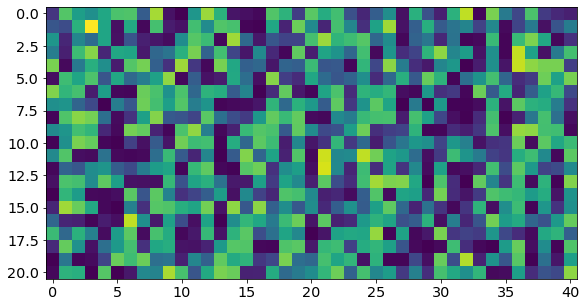

In [86]:
plt.imshow(validation[1][:,parent_idx1])

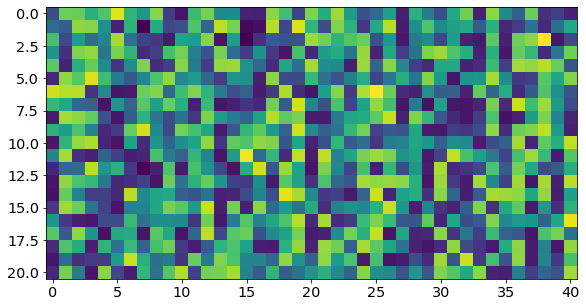

In [87]:
plt.imshow(o[1][:,parent_idx1])

In [88]:
r[parent_idx1].head(NUM_TIME_STEPS)

,0,4,9,14,22,24,25,35,36,37,...,84,86,89,90,91,92,95,97,98,99
0,0.098245,0.609967,0.815135,0.401051,0.562713,0.763025,0.764922,0.652748,0.148571,0.231261,...,0.491686,0.717976,0.001015,0.695888,0.405475,0.184986,0.807333,0.112628,0.087484,0.027521
1,0.326541,0.191546,0.465289,0.777389,0.229073,0.090056,0.647742,0.504558,0.190697,0.439126,...,0.451409,0.473438,0.154350,0.474667,0.046464,0.164368,0.266559,0.041934,0.221453,0.424801
2,0.558019,0.177261,0.405180,0.329462,0.477147,0.658833,0.446291,0.102005,0.153157,0.011604,...,0.477579,0.018722,0.016384,0.665163,0.039241,0.836555,0.760361,0.743217,-0.003802,0.160750
3,0.414868,0.049850,0.581553,0.806600,0.386016,0.484457,0.287406,0.038823,0.283108,0.493017,...,0.533319,0.531678,0.005041,0.461681,0.031183,0.820010,0.572457,0.056631,0.239487,0.891512
4,0.737382,0.043373,0.510735,0.788161,0.466573,0.058602,0.450196,0.663108,0.189596,0.107139,...,0.546135,-0.008100,0.065166,0.506545,0.113121,0.698480,0.691177,0.570465,0.814967,0.239212
5,0.059804,0.781272,0.552581,0.810776,0.366330,0.074149,0.090057,0.111155,0.112396,0.699073,...,0.026291,0.390346,0.339260,0.699142,0.522473,0.113476,0.138153,0.624870,0.529052,0.668812
6,0.781514,0.731488,0.775093,0.169254,0.543781,0.008830,0.055478,0.540746,0.306924,0.231684,...,0.203070,0.039702,0.829847,0.297914,0.523539,0.045321,0.262077,0.532374,0.540264,0.301659
7,0.577203,0.444771,0.355280,0.307468,-0.007528,0.255132,0.252719,0.057385,0.153163,0.565001,...,0.014418,0.013628,0.020176,0.795134,0.057048,0.800154,0.505240,0.594356,0.405648,0.083112
8,0.033472,0.725192,0.702464,0.520739,0.164022,0.039594,0.065129,0.059735,0.677326,0.216887,...,0.005071,0.039201,0.079928,0.565781,0.020633,0.088241,0.401950,0.700070,0.432037,0.086613
9,0.453818,0.476405,0.623707,0.359937,0.014259,0.074212,0.666202,0.275406,0.238147,0.166318,...,0.078190,0.139036,0.123556,0.674336,0.026353,0.664910,0.743821,0.637300,0.565073,0.044531


In [89]:
v[parent_idx1].head(NUM_TIME_STEPS)

,0,4,9,14,22,24,25,35,36,37,...,84,86,89,90,91,92,95,97,98,99
0,0.165539,0.764241,0.263854,0.386694,0.509230,0.741127,0.675659,0.620824,0.200082,0.070399,...,0.659138,0.626613,0.067647,0.797150,0.418742,0.278836,0.649797,0.085651,0.117422,0.029811
1,0.312090,0.220041,0.782636,0.579574,0.254949,0.050609,0.654473,0.751116,0.125721,0.504904,...,0.376792,0.491349,0.183897,0.527174,0.032882,0.104773,0.301571,0.066040,0.325206,0.527713
2,0.590390,0.134658,0.560478,0.297122,0.714888,0.783808,0.465749,0.328685,0.300857,0.113560,...,0.436288,0.007368,0.042005,0.784495,0.049530,0.721235,0.787071,0.746020,0.015249,0.172700
3,0.410304,0.044856,0.374979,0.921963,0.071594,0.390394,0.173835,0.230194,0.359003,0.570373,...,0.540599,0.491497,0.045832,0.447294,0.009768,0.723892,0.632848,0.033391,0.253742,0.739978
4,0.824310,0.040861,0.353298,0.592411,0.464934,0.376307,0.403981,0.669590,0.018039,0.085080,...,0.551812,0.005616,0.098045,0.571893,0.098564,0.747784,0.748598,0.623549,0.761574,0.179846
5,0.034440,0.737795,0.435759,0.312432,0.464916,0.228664,0.668561,0.398946,0.030819,0.060310,...,0.018091,0.455207,0.481704,0.751375,0.390982,0.129553,0.167465,0.651345,0.470322,0.610358
6,0.627490,0.645237,0.622896,0.260557,0.603850,0.028477,0.040399,0.540659,0.165949,0.197917,...,0.186601,0.026784,0.842857,0.289008,0.598306,0.102617,0.292341,0.455817,0.523958,0.229819
7,0.496774,0.583216,0.282470,0.222698,0.026805,0.594165,0.314487,0.100662,0.037279,0.161996,...,0.061217,0.041553,0.025505,0.765915,0.088971,0.783222,0.683340,0.668231,0.384354,0.136575
8,0.015199,0.773253,0.680078,0.574472,0.014102,0.056176,0.139442,0.034239,0.867243,0.059017,...,0.024474,0.014480,0.105239,0.730722,0.000469,0.020981,0.395696,0.772237,0.310642,0.109342
9,0.684259,0.633812,0.629710,0.083049,0.003627,0.028873,0.769490,0.401291,0.110672,0.608051,...,0.084736,0.147846,0.208304,0.786774,0.045683,0.721827,0.690326,0.761193,0.537486,0.030887


In [90]:
ignore_noParent_MSE(validation, o)

<tf.Tensor: shape=(), dtype=float32, numpy=0.019765563>

# Test OG SHAP

microsoft shap sucks

In [124]:
def compute_SHAP_feature_importance(shap_values, num_samples, feature_indices, NUM_TIME_STEPS, NUM_TARGETS):

    shap_values = np.reshape(shap_values, newshape=(NUM_TIME_STEPS, NUM_TARGETS, num_samples, NUM_TIME_STEPS, NUM_TARGETS)) 
    """
    Computes a feature importance matrix from the SHAP values for an autoencoder model.
    
    Args:
        shap_values (numpy.ndarray): A 5D array of SHAP values with dimensions
            (output timestep, output feature, number of samples, number of input time steps, number of input features).
        feature_indices (numpy.ndarray): 1D array containing indices of the features we're interested in.
            
    Returns:
        numpy.ndarray: A 2D feature importance matrix with dimensions (output feature, input feature),
            where each element is a normalized importance value between 0 and 1.
    """
    mask = np.zeros(shap_values.shape[1], dtype=bool)
    mask[feature_indices] = True

    # Zero out the SHAP values for the features we're not interested in
    masked_shap_values = np.copy(shap_values)
    masked_shap_values[:, ~mask, :, :] = 0

    # Compute the feature importance matrix
    feature_importance = np.sum(np.abs(masked_shap_values), axis=(0, 2, 3))

    # Normalize to [0, 1]
    feature_importance_normalized = feature_importance / np.max(feature_importance)

    return feature_importance_normalized

In [111]:
allMF = allMF.reshape((5,100,1,100))
allMFGold.shape

(5, 100, 100)

In [104]:
superParentsMF, parentIDX_MF = load_dream4.getSuperParents(allMFGold)

In [105]:
mse_noParent1_MF = GRND_AutoEncoderModels.get_ignore_noParent_MSE(parentIDX_MF[0])

In [112]:
allMF.shape

(5, 100, 1, 100)

In [113]:
allMF[0:4][:].shape

(4, 100, 1, 100)

In [115]:
denseMF = GRND_AutoEncoderModels.modelDense_AutoEncoder(superParentsMF[0], superParentsMF[0], NUM_TARGETS, 1, num_hidden_units=sum(parentIDX_MF[0]), sparsity=0.0)
denseMF.compile(optimizer='adam', loss= mse_noParent1_MF)
denseMF.fit(allMF[0:4].reshape((400, 1,100)), allMF[0:4].reshape((400, 1,100)), epochs=50,  verbose=True, validation_data=(allMF[4:5].reshape((100, 1,100)), allMF[4:5].reshape((100, 1,100))),
          callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()])

Epoch 1/300
13/13 [==============================] - 2s 40ms/step - loss: 0.0626 - val_loss: 0.0543
Epoch 2/300
13/13 [==============================] - 0s 13ms/step - loss: 0.0229 - val_loss: 0.0426
Epoch 3/300
13/13 [==============================] - 0s 12ms/step - loss: 0.0161 - val_loss: 0.0417
Epoch 4/300
13/13 [==============================] - 0s 10ms/step - loss: 0.0134 - val_loss: 0.0378
Epoch 5/300
13/13 [==============================] - 0s 10ms/step - loss: 0.0114 - val_loss: 0.0326
Epoch 6/300
13/13 [==============================] - 0s 10ms/step - loss: 0.0096 - val_loss: 0.0293
Epoch 7/300
13/13 [==============================] - 0s 10ms/step - loss: 0.0082 - val_loss: 0.0269
Epoch 8/300
13/13 [==============================] - 0s 10ms/step - loss: 0.0069 - val_loss: 0.0231
Epoch 9/300
13/13 [==============================] - 0s 9ms/step - loss: 0.0059 - val_loss: 0.0203
Epoch 10/300
13/13 [==============================] - 0s 9ms/step - loss: 0.0050 - val_loss: 0.0188
E

In [101]:
denseMF.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 1, 100)]     0           []                               
                                                                                                  
 prune_low_magnitude_dae__encod  (None, 1, 100)      20002       ['input_8[0][0]']                
 er_mask_5 (PruneLowMagnitude)                                                                    
                                                                                                  
 conv1d_5 (Conv1D)              (None, 1, 100)       10100       ['prune_low_magnitude_dae__encode
                                                                 r_mask_5[0][0]']                 
                                                                                            

In [117]:
inp = Input(shape=(1,NUM_TARGETS))
re = tf.keras.layers.Reshape(target_shape=(1, NUM_TARGETS))(inp)
dout = denseMF(re)
doutReMF = tf.squeeze(tf.keras.layers.Reshape(target_shape=(1*NUM_TARGETS,1))(dout), axis=-1)
denseREMF = tf.keras.Model(inputs=inp, outputs=doutReMF)

In [118]:
denseREMF.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 1, 100)]          0         
                                                                 
 reshape_13 (Reshape)        (None, 1, 100)            0         
                                                                 
 model_10 (Functional)       (None, 1, 100)            614677    
                                                                 
 reshape_14 (Reshape)        (None, 100, 1)            0         
                                                                 
 tf.compat.v1.squeeze_1 (TFO  (None, 100)              0         
 pLambda)                                                        
                                                                 
Total params: 614,677
Trainable params: 604,675
Non-trainable params: 10,002
_______________________________________________

In [121]:
h = shap.GradientExplainer(denseREMF,
    #(model.layers[0].input, model.layers[-1].output),
    allMF[0:4].reshape((400, 1,100)),
    local_smoothing=0 # std dev of smoothing noise
)
sv = h.shap_values(allMF[4:5].reshape((100, 1,100)))
# shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

Number of features: 100


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [02:31<00:00,  1.51s/it]


In [122]:
uvMF = np.copy(sv)

TPR:  0.028409090909090908
TNR:  0.9825936482084691
FPR:  0.017406351791530945
FNR:  0.9715909090909091


(0.028409090909090908,
 0.9825936482084691,
 0.017406351791530945,
 0.9715909090909091)

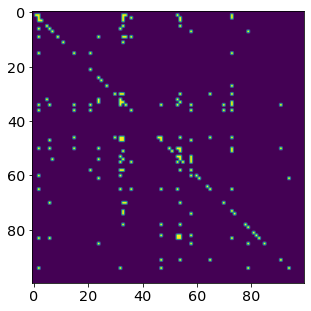

In [127]:
shapOUTMF = compute_SHAP_feature_importance(uvMF, 100, parentIDX_MF[0], 1, 100 )
shapMaskMF = get_top_mask(allMFGold[0], shapOUTMF)
plt.imshow(shapMaskMF)
evaluate_masks(allMFGold[0], shapMaskMF)

In [128]:
denseMF = GRND_AutoEncoderModels.modelDense_AutoEncoder(shapMaskMF, shapMaskMF, NUM_TARGETS, 1, num_hidden_units=sum(parentIDX_MF[0]), sparsity=0.0)
denseMF.compile(optimizer='adam', loss= mse_noParent1_MF)
denseMF.fit(allMF[0:4].reshape((400, 1,100)), allMF[0:4].reshape((400, 1,100)), epochs=50,  verbose=True, validation_data=(allMF[4:5].reshape((100, 1,100)), allMF[4:5].reshape((100, 1,100))),
          callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()])

Epoch 1/50
13/13 [==============================] - 2s 41ms/step - loss: 0.1570 - val_loss: 0.0947
Epoch 2/50
13/13 [==============================] - 0s 12ms/step - loss: 0.1142 - val_loss: 0.0809
Epoch 3/50
13/13 [==============================] - 0s 12ms/step - loss: 0.0944 - val_loss: 0.0691
Epoch 4/50
13/13 [==============================] - 0s 11ms/step - loss: 0.0804 - val_loss: 0.0622
Epoch 5/50
13/13 [==============================] - 0s 11ms/step - loss: 0.0713 - val_loss: 0.0586
Epoch 6/50
13/13 [==============================] - 0s 11ms/step - loss: 0.0651 - val_loss: 0.0569
Epoch 7/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0607 - val_loss: 0.0558
Epoch 8/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0575 - val_loss: 0.0550
Epoch 9/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0551 - val_loss: 0.0541
Epoch 10/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0532 - val_loss: 0.0539
Epoch 11/50


In [ ]:
######################################

In [ ]:
dense = GRND_AutoEncoderModels.modelDense_AutoEncoder(superParent1, superParent1, NUM_TARGETS, NUM_TIME_STEPS, num_hidden_units=NUM_PARENTS1, sparsity=0.0)
dense.compile(optimizer='adam', loss= ignore_noParent_MSE)
dense.fit(beanIntensities, beanIntensities, epochs=300,  verbose=False, validation_data=(validation, validation),
          callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()])

In [ ]:
inp = Input(shape=(NUM_TIME_STEPS,NUM_TARGETS))
re = tf.keras.layers.Reshape(target_shape=(NUM_TIME_STEPS, NUM_TARGETS))(inp)
dout = dense(re)
doutRe = tf.squeeze(tf.keras.layers.Reshape(target_shape=(NUM_TIME_STEPS*NUM_TARGETS,1))(dout), axis=-1)
denseRE = tf.keras.Model(inputs=inp, outputs=doutRe)

In [ ]:

model = denseRE
# def map2layer(x, layer):1
#     feed_dict = dict(zip([model.layers[0].input.ref()], [x.copy()]))
#     return K.get_session().run(model.layers[layer].input, feed_dict)


e = shap.GradientExplainer(model,
    #(model.layers[0].input, model.layers[-1].output),
    allData,
    local_smoothing=0 # std dev of smoothing noise
)
sv = e.shap_values(validation)
# shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

In [ ]:
uv = np.copy(sv)

In [ ]:
shapOUT = compute_SHAP_feature_importance(uv, 2)

In [ ]:
shapMask = get_top_mask(goldIm, shapOUT)
plt.imshow(shapMask)

In [ ]:
evaluate_masks(goldIm, shapMask)

In [ ]:
shapNet = GRND_AutoEncoderModels.modelDense_AutoEncoder(shapMask, shapMask, NUM_TARGETS, NUM_TIME_STEPS, num_hidden_units=NUM_PARENTS1, sparsity=0.0)
shapNet.compile(optimizer='adam', loss= ignore_noParent_MSE)
shapNet.fit(beanIntensities, beanIntensities, epochs=300,  verbose=True, validation_data=(validation, validation),
          callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()])

In [ ]:
#load dream4 mult
allMF, allMFGold, _ = load_dream4.load_all_dream4_MultiFactorial()

# Lazy Kernels

In [ ]:
dense = GRND_AutoEncoderModels.modelDense_AutoEncoder(superParent1, superParent1, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
dense.compile(optimizer=tf.keras.optimizers.Adam(), loss=ignore_noParent_MSE)

In [ ]:
d = np.array(dense.get_weights())

In [ ]:
d[0].shape

In [ ]:


def do_lazy_train(epochs, modelNum, hidden = NUM_PARENTS1):

    '''trains the auto encoder epoch by epoch and returns the weights of the first layer. 
    modelNum: 0 = ordinary autoencoder, 1 = dense autoencoder, 2 = denseLstm autoencoder'''
    ep = epochs
    #hidden = [hidden,] #range(1,32)
    lossMatrix = []
    lazy_weights = []

    if modelNum == 0:
        model = GRND_AutoEncoderModels.modelDense_AutoEncoder(superParent1, superParent1, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, hidden)
    if modelNum == 1: 
        model = GRND_AutoEncoderModels.modelSuperParent_AutoEncoder(superParent1, superParent1, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, hidden)
    if modelNum == 2: 
        model  = GRND_AutoEncoderModels.modelDense_AutoEncoder(superParent1, superParent1, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, num_hidden_units=NUM_PARENTS1, useRNN=True)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=ignore_noParent_MSE)
    
    # dense = modelDense2(superParent1, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, num_hidden_units=hidden)
    # dense.compile(optimizer=tf.keras.optimizers.Adam(), loss=ignore_noParent_MSE)

    #for i in tqdm(range(ep)):
    for i in range(ep):
        model.fit(beanIntensities, beanIntensities, validation_data=(validation, validation), epochs=1,  verbose=0, callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()])
        lazy_weights.append(dw := model.get_weights()[0])
        test = model(validation) #, verbose = 0)
        loss = ignore_noParent_MSE(validation, test)
        lossMatrix.append(loss)
        
    lossMatrix = np.array(lossMatrix) #loss matrix no longer returns anything 
    lazy_weights = np.array(lazy_weights)
    # print("lazy weights", lazy_weights.shape)

    return lossMatrix, lazy_weights #loss matrix no longer returns anything 

In [ ]:
#https://proceedings.mlr.press/v162/rachwan22a/rachwan22a.pdf Winning the Lottery Ticket Ahead of Time:
def lazyKernelRegime(w, parent_idx1=parent_idx1):
    '''compute when each weight enters lazy kernel regime'''
    
    # print("wshape", w.shape)

    firstLayer = [] 
    for i in range(len(w)):
         firstLayer.append(w[i]) #firstLayer.append(w[i][parent_idx1])

    fL = np.array(firstLayer)    
    # print("print fL", fL.shape, fL.dtype, fL[0], fL[1],)
    d0 = np.square(fL[1] - fL[0])
    # print("do", d0.shape, d0)
    
    kernelChange = []
    for i in range(1,len(fL)):
        dt = np.square(fL[i] - fL[0])
        dt_minus1 = np.square(fL[i-1] - fL[0])   
        d = np.abs(dt - dt_minus1)/d0                        #eq 11 from the paper
        kernelChange.append(d)
    
    kernelChange = np.moveaxis(kernelChange, 0, 2)
    # plt.plot(kernelChange[0][0]);
    # plt.title("$|\Delta W|$ vs Epoch")
    # plt.xlabel("Epoch")
    # plt.ylabel("$|\Delta W|$")

    return np.array(kernelChange)

In [ ]:
#TODO: try setting top parents to num epochs trained rather than culling process
def compute_distrib(change, t, raw = False): #raw means return the unshaped indicies. 
    stop = []

    z = np.zeros(shape=(NUM_TARGETS, NUM_TARGETS))


    for parent in range(len(change)):
        for child in range(len(change[0])):
            try:
                z[parent][child] = (np.min(np.argwhere(change[parent][child] < t)))
            except ValueError:
                stop.append(len(change))

    return z 
    
    stop = np.array(stop)
    # print("stop shape", stop.shape)
    # print(stop.shape)
    var = np.std(stop)
    # print(var)
    # assert(False)
    mean = np.average(stop)
   # print("mean, variance", mean, var)
    top_parents = np.argwhere(stop > (mean + 0.5*var)) #get the parents which take more than 2 stds to stop training
    # print("top parents ", top_parents)
    # assert(False)
    top_parent_child = []
    for tp in top_parents:
        top_parent_child.append(np.unravel_index(tp, shape = (NUM_PARENTS1, NUM_TARGETS)))

    if raw == False:
        plt.hist(stop)
        plt.xlabel("Epoch where regulator-target-weight began changing by at most "+ str(t));
        plt.ylabel("Number of parent-child-weights");
        plt.title("Histogram of weight stops");
        print("average stop: ", mean);

    if raw == True:
        return np.array(top_parents)

    return np.array(top_parent_child)

In [ ]:
def lazyKernels(N, model_num=0):
    '''N: number of trials
        modelNum: 0 = ordinary autoencoder, 1 = dense autoencoder, 2 = denseLstm autoencoder'''

    candidates = []
    final_w = []
    for i in tqdm(range(N)):
        lm, lazy_weights = do_lazy_train(epochs=300, modelNum=model_num)
        # print("lm", lm)
        change = lazyKernelRegime(lazy_weights)
        # print("change",change.shape)
        # assert(False)
        top_pr = np.squeeze(compute_distrib(change, t = 0.2, raw=True))
        candidates.append(top_pr)
        final_w.append(lazy_weights[-1]) #final w is used for magntiude calculations at the end
        tf.keras.backend.clear_session()
    
    final_w = np.array(final_w)
    firstLayer = []
    for i in range(len(final_w)):
        firstLayer.append(np.abs(final_w[i])) #firstLayer.append(np.abs(final_w[i][parent_idx1]))
    fw = np.array(firstLayer)
    candidates = np.array(candidates)

    fw_avg = np.average(fw, axis = 0)
    stop_avg = np.average(candidates, axis=0) 

    return stop_avg, fw_avg
    #print(fw_avg.shape)
    
    candidates = np.hstack(candidates)
    candidates = candidates.reshape(candidates.size)
    #print(candidates.shape)

    # plt.hist(candidates, bins=np.arange(0, NUM_PARENTS1*NUM_TARGETS))
    # plt.title("Parent-Child Regulator Histogram")
    # plt.xlabel("Parent-Child Weight")
    # plt.ylabel("Num-Times parent-child relationship trained for top 5% of time")
    return candidates, fw_avg




In [ ]:
#TODO: test reshaping in other orientation

In [ ]:
can, mag = lazyKernels(N = 5)

In [ ]:
score = np.multiply(can, mag)

In [ ]:
evaluate_masks(goldIm,score)

In [ ]:
obs_mask = get_top_mask(goldIm, score)

In [ ]:
# obs_enc = GRND_AutoEncoderModels.modelSuperParent_AutoEncoder(superParent1, superParent1, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1,sparsity=0.9824)
# obs_enc.compile(optimizer='adam', loss= ignore_noParent_MSE)
# obs_enc.fit(beanIntensities, beanIntensities, epochs=300,  verbose=True, validation_data=(validation, validation),
#           callbacks = [
#     tfmot.sparsity.keras.UpdatePruningStep()])

In [ ]:
obs_enc = GRND_AutoEncoderModels.modelSuperParent_AutoEncoder(obs_mask, obs_mask, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
obs_enc.compile(optimizer='adam', loss= ignore_noParent_MSE)
obs_enc.fit(beanIntensities, beanIntensities, epochs=300,  verbose=True, validation_data=(validation, validation),
          callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()])


In [ ]:
def test_all(N): 

    def testOrdinary(N=N):

        #test val acc
        acc = [] 
        for i in range(N):
            looseParent = GRND_AutoEncoderModels.modelSuperParent_AutoEncoder(superParent1, superParent1, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
            looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
            o = looseParent.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                                validation_data=(validation, validation), callbacks = [
                tfmot.sparsity.keras.UpdatePruningStep()])
            a = looseParent.evaluate(validation, validation) 
            acc.append(a) 


        can, mag = lazyKernels(N = N, model_num=0)
        score = np.multiply(can, mag)

        #test obd
        print("Testing OBD")
        tp, tn, fp, fn = evaluate_masks(goldIm,score)
        obdmetrics = [ tp, tn, fp, fn ]
        obdmask = get_top_mask(goldIm, score) 

        #test mag
        print("Testing magnitude pruning")
        mtp, mtn, mfp, mfn = evaluate_masks(goldIm,mag)
        magmetrics = [mtp, mtn, mfp, mfn] 
        magMask = get_top_mask(goldIm,mag) 
        
        #test shap
        print("Testing SHAP")
        looseParent = GRND_AutoEncoderModels.modelSuperParent_AutoEncoder(superParent1, superParent1, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
        looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
        o = looseParent.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                            validation_data=(validation, validation), callbacks = [
            tfmot.sparsity.keras.UpdatePruningStep()])
        inp = Input(shape=(NUM_TIME_STEPS,NUM_TARGETS))
        re = tf.keras.layers.Reshape(target_shape=(NUM_TIME_STEPS, NUM_TARGETS))(inp)
        dout = looseParent(re)
        doutRe = tf.squeeze(tf.keras.layers.Reshape(target_shape=(NUM_TIME_STEPS*NUM_TARGETS,1))(dout), axis=-1)
        shapModel = tf.keras.Model(inputs=inp, outputs=doutRe)

        e = shap.GradientExplainer(shapModel,
            #(model.layers[0].input, model.layers[-1].output),
            beanIntensities,
            local_smoothing=0 # std dev of smoothing noise
        )
        
        sv = e.shap_values(validation)
        uv = np.copy(sv)
        shapOUT = compute_SHAP_feature_importance(uv, 2)
        shapMask = get_top_mask(goldIm, shapOUT)
        stp, stn, sfp, sfn  = evaluate_masks(goldIm, shapMask)
        shapmetrics = [stp, stn, sfp, sfn ] 


        #test masks 
        print("Testing Masks")
        obdAcc = []
        magAcc = [] 
        shapAcc = []
        goldAcc = []
        for i in range(N):
            obdMod = GRND_AutoEncoderModels.modelSuperParent_AutoEncoder(obdmask, obdmask, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
            obdMod.compile(optimizer='adam', loss=ignore_noParent_MSE)
            o = obdMod.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                                validation_data=(validation, validation), callbacks = [
                tfmot.sparsity.keras.UpdatePruningStep()])
            a = obdMod.evaluate(validation, validation) 
            obdAcc.append(a) 

            magmod = GRND_AutoEncoderModels.modelSuperParent_AutoEncoder(magMask, magMask, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
            magmod.compile(optimizer='adam', loss=ignore_noParent_MSE)
            o = magmod.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                                validation_data=(validation, validation), callbacks = [
                tfmot.sparsity.keras.UpdatePruningStep()])
            a = magmod.evaluate(validation, validation) 
            magAcc.append(a) 

            shapmod = GRND_AutoEncoderModels.modelSuperParent_AutoEncoder(shapMask, shapMask, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
            shapmod.compile(optimizer='adam', loss=ignore_noParent_MSE)
            o = shapmod.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                                validation_data=(validation, validation), callbacks = [
                tfmot.sparsity.keras.UpdatePruningStep()])
            a = shapmod.evaluate(validation, validation) 
            shapAcc.append(a)


            shapmod = GRND_AutoEncoderModels.modelSuperParent_AutoEncoder(goldIm, goldIm, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
            shapmod.compile(optimizer='adam', loss=ignore_noParent_MSE)
            o = shapmod.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                                validation_data=(validation, validation), callbacks = [
                tfmot.sparsity.keras.UpdatePruningStep()])
            a = shapmod.evaluate(validation, validation) 
            goldAcc.append(a)

        obdAcc = np.array(obdAcc)
        magAcc = np.array(magAcc)
        shapAcc = np.array(shapAcc)
        goldAcc = np.array(goldAcc) 
        print("obdAcc, magAcc, shapAcc, goldAcc", np.average(obdAcc), np.average(magAcc), np.average(shapAcc))
        return obdmetrics, magmetrics, shapmetrics, np.average(obdAcc), np.average(magAcc), np.average(shapAcc), np.average(goldAcc)
    print("---------------------Testing Ordinary AE--------------------")
    obdmetrics, magmetrics, shapmetrics, obdAcc, magAcc, shapAcc, goldAcc = testOrdinary()
    allOrdinary = [obdmetrics, magmetrics, shapmetrics, obdAcc, magAcc, shapAcc, goldAcc]

    def testDense():
        
        #test val acc
        acc = [] 
        for i in range(N):
            looseParent = GRND_AutoEncoderModels.modelDense_AutoEncoder(superParent1, superParent1, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
            looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
            o = looseParent.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                                validation_data=(validation, validation), callbacks = [
                tfmot.sparsity.keras.UpdatePruningStep()])
            a = looseParent.evaluate(validation, validation) 
            acc.append(a) 


        can, mag = lazyKernels(N = N, model_num=1)
        score = np.multiply(can, mag)

        #test obd
        print("Testing OBD")
        tp, tn, fp, fn = evaluate_masks(goldIm,score)
        obdmetrics = [ tp, tn, fp, fn ]
        obdmask = get_top_mask(goldIm, score) 

        #test mag
        print("Testing magnitude pruning")
        mtp, mtn, mfp, mfn = evaluate_masks(goldIm,mag)
        magmetrics = [mtp, mtn, mfp, mfn] 
        magMask = get_top_mask(goldIm,mag) 
        
        #test shap
        print("Testing SHAP")
        looseParent = GRND_AutoEncoderModels.modelDense_AutoEncoder(superParent1, superParent1, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
        looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
        o = looseParent.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                            validation_data=(validation, validation), callbacks = [
            tfmot.sparsity.keras.UpdatePruningStep()])
        inp = Input(shape=(NUM_TIME_STEPS,NUM_TARGETS))
        re = tf.keras.layers.Reshape(target_shape=(NUM_TIME_STEPS, NUM_TARGETS))(inp)
        dout = looseParent(re)
        doutRe = tf.squeeze(tf.keras.layers.Reshape(target_shape=(NUM_TIME_STEPS*NUM_TARGETS,1))(dout), axis=-1)
        shapModel = tf.keras.Model(inputs=inp, outputs=doutRe)

        e = shap.GradientExplainer(shapModel,
            #(model.layers[0].input, model.layers[-1].output),
            beanIntensities,
            local_smoothing=0 # std dev of smoothing noise
        )
        
        sv = e.shap_values(validation)
        uv = np.copy(sv)
        shapOUT = compute_SHAP_feature_importance(uv, 2)
        shapMask = get_top_mask(goldIm, shapOUT)
        stp, stn, sfp, sfn  = evaluate_masks(goldIm, shapMask)
        shapmetrics = [stp, stn, sfp, sfn ] 


        #test masks 
        print("Testing Masks")
        obdAcc = []
        magAcc = [] 
        shapAcc = []
        goldAcc = []
        for i in range(N):
            obdMod = GRND_AutoEncoderModels.modelDense_AutoEncoder(obdmask, obdmask, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
            obdMod.compile(optimizer='adam', loss=ignore_noParent_MSE)
            o = obdMod.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                                validation_data=(validation, validation), callbacks = [
                tfmot.sparsity.keras.UpdatePruningStep()])
            a = obdMod.evaluate(validation, validation) 
            obdAcc.append(a) 

            magmod = GRND_AutoEncoderModels.modelDense_AutoEncoder(magMask, magMask, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
            magmod.compile(optimizer='adam', loss=ignore_noParent_MSE)
            o = magmod.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                                validation_data=(validation, validation), callbacks = [
                tfmot.sparsity.keras.UpdatePruningStep()])
            a = magmod.evaluate(validation, validation) 
            magAcc.append(a) 

            shapmod = GRND_AutoEncoderModels.modelDense_AutoEncoder(shapMask, shapMask, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
            shapmod.compile(optimizer='adam', loss=ignore_noParent_MSE)
            o = shapmod.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                                validation_data=(validation, validation), callbacks = [
                tfmot.sparsity.keras.UpdatePruningStep()])
            a = shapmod.evaluate(validation, validation) 
            shapAcc.append(a)


            goldmodel = GRND_AutoEncoderModels.modelDense_AutoEncoder(goldIm, goldIm, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
            goldmodel.compile(optimizer='adam', loss=ignore_noParent_MSE)
            o = goldmodel.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                                validation_data=(validation, validation), callbacks = [
                tfmot.sparsity.keras.UpdatePruningStep()])
            a = goldmodel.evaluate(validation, validation) 
            goldAcc.append(a)

        obdAcc = np.array(obdAcc)
        magAcc = np.array(magAcc)
        shapAcc = np.array(shapAcc)
        goldAcc = np.array(goldAcc) 
        print("obdAcc, magAcc, shapAcc, goldAcc", np.average(obdAcc), np.average(magAcc), np.average(shapAcc))
        return obdmetrics, magmetrics, shapmetrics, np.average(obdAcc), np.average(magAcc), np.average(shapAcc), np.average(goldAcc)

    print("---------------------Dense AE--------------------")
    obdmetrics, magmetrics, shapmetrics, obdAcc, magAcc, shapAcc, goldAcc = testDense()
    allDense = [obdmetrics, magmetrics, shapmetrics, obdAcc, magAcc, shapAcc, goldAcc]
    
    def testLSTM():
        acc = [] 
        for i in range(N):
            looseParent = GRND_AutoEncoderModels.modelSuperParent_AutoEncoder(superParent1, superParent1, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
            looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
            o = looseParent.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                                validation_data=(validation, validation), callbacks = [
                tfmot.sparsity.keras.UpdatePruningStep()])
            a = looseParent.evaluate(validation, validation) 
            acc.append(a) 


        can, mag = lazyKernels(N = N, model_num=2)
        score = np.multiply(can, mag)

        #test obd
        print("Testing OBD")
        tp, tn, fp, fn = evaluate_masks(goldIm,score)
        obdmetrics = [ tp, tn, fp, fn ]
        obdmask = get_top_mask(goldIm, score) 

        #test mag
        print("Testing magnitude pruning")
        mtp, mtn, mfp, mfn = evaluate_masks(goldIm,mag)
        magmetrics = [mtp, mtn, mfp, mfn] 
        magMask = get_top_mask(goldIm,mag) 
        
        #test shap
        print("Testing SHAP")
        looseParent = GRND_AutoEncoderModels.modelDense_AutoEncoder(superParent1, superParent1, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, num_hidden_units=NUM_PARENTS1, sparsity=0.0, useRNN=True)
        looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
        o = looseParent.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                            validation_data=(validation, validation), callbacks = [
            tfmot.sparsity.keras.UpdatePruningStep()])
        inp = Input(shape=(NUM_TIME_STEPS,NUM_TARGETS))
        re = tf.keras.layers.Reshape(target_shape=(NUM_TIME_STEPS, NUM_TARGETS))(inp)
        dout = looseParent(re)
        doutRe = tf.squeeze(tf.keras.layers.Reshape(target_shape=(NUM_TIME_STEPS*NUM_TARGETS,1))(dout), axis=-1)
        shapModel = tf.keras.Model(inputs=inp, outputs=doutRe)

        e = shap.GradientExplainer(shapModel,
            #(model.layers[0].input, model.layers[-1].output),
            beanIntensities,
            local_smoothing=0 # std dev of smoothing noise
        )
        
        sv = e.shap_values(validation)
        uv = np.copy(sv)
        shapOUT = compute_SHAP_feature_importance(uv, 2)
        shapMask = get_top_mask(goldIm, shapOUT)
        stp, stn, sfp, sfn  = evaluate_masks(goldIm, shapMask)
        shapmetrics = [stp, stn, sfp, sfn ] 


        #test masks 
        print("Testing Masks")
        obdAcc = []
        magAcc = [] 
        shapAcc = []
        goldAcc = []
        for i in range(N):
            obdMod = GRND_AutoEncoderModels.modelDense_AutoEncoder(obdmask, obdmask, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, num_hidden_units=NUM_PARENTS1, sparsity=0.0, useRNN=True)
            obdMod.compile(optimizer='adam', loss=ignore_noParent_MSE)
            o = obdMod.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                                validation_data=(validation, validation), callbacks = [
                tfmot.sparsity.keras.UpdatePruningStep()])
            a = obdMod.evaluate(validation, validation) 
            obdAcc.append(a) 

            magmod = GRND_AutoEncoderModels.modelDense_AutoEncoder(magMask, magMask, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, num_hidden_units=NUM_PARENTS1, sparsity=0.0, useRNN=True)
            magmod.compile(optimizer='adam', loss=ignore_noParent_MSE)
            o = magmod.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                                validation_data=(validation, validation), callbacks = [
                tfmot.sparsity.keras.UpdatePruningStep()])
            a = magmod.evaluate(validation, validation) 
            magAcc.append(a) 

            shapmod = GRND_AutoEncoderModels.modelDense_AutoEncoder(shapMask, shapMask, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, num_hidden_units=NUM_PARENTS1, sparsity=0.0, useRNN=True)
            shapmod.compile(optimizer='adam', loss=ignore_noParent_MSE)
            o = shapmod.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                                validation_data=(validation, validation), callbacks = [
                tfmot.sparsity.keras.UpdatePruningStep()])
            a = shapmod.evaluate(validation, validation) 
            shapAcc.append(a)


            goldmodel = GRND_AutoEncoderModels.modelDense_AutoEncoder(goldIm, goldIm, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, num_hidden_units=NUM_PARENTS1, sparsity=0.0, useRNN=True)
            goldmodel.compile(optimizer='adam', loss=ignore_noParent_MSE)
            o = goldmodel.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                                validation_data=(validation, validation), callbacks = [
                tfmot.sparsity.keras.UpdatePruningStep()])
            a = goldmodel.evaluate(validation, validation) 
            goldAcc.append(a)

        obdAcc = np.array(obdAcc)
        magAcc = np.array(magAcc)
        shapAcc = np.array(shapAcc)
        goldAcc = np.array(goldAcc) 

        print("obdAcc, magAcc, shapAcc, goldAcc", np.average(obdAcc), np.average(magAcc), np.average(shapAcc))
        return obdmetrics, magmetrics, shapmetrics, np.average(obdAcc), np.average(magAcc), np.average(shapAcc), np.average(goldAcc)
    
    print("---------------------Dense-LSTM AE--------------------")
    obdmetrics, magmetrics, shapmetrics, obdAcc, magAcc, shapAcc, goldAcc = testLSTM()
    allLSTM = [obdmetrics, magmetrics, shapmetrics, obdAcc, magAcc, shapAcc, goldAcc]

    return allOrdinary, allDense, allLSTM
    

In [ ]:
allOrdinary, allDense, allLSTM = test_all(2)

In [ ]:
allOrdinary[3:] #obd, mag, shap, gold

In [ ]:
allDense[3:]

In [ ]:
allLSTM [3:]

In [ ]:
def testOrdinary(N=2):

    #test val acc
    acc = [] 
    for i in range(N):
        looseParent = GRND_AutoEncoderModels.modelSuperParent_AutoEncoder(superParent1, superParent1, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
        looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
        o = looseParent.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                            validation_data=(validation, validation), callbacks = [
            tfmot.sparsity.keras.UpdatePruningStep()])
        a = looseParent.evaluate(validation, validation) 
        acc.append(a) 


    can, mag = lazyKernels(N = N, model_num=0)
    score = np.multiply(can, mag)

    #test obd
    print("Testing OBD")
    tp, tn, fp, fn = evaluate_masks(goldIm,score)
    obdmetrics = [ tp, tn, fp, fn ]
    obdmask = get_top_mask(goldIm, score) 

    #test mag
    print("Testing magnitude pruning")
    mtp, mtn, mfp, mfn = evaluate_masks(goldIm,mag)
    magmetrics = [mtp, mtn, mfp, mfn] 
    magMask = get_top_mask(goldIm,mag) 
    
    #test shap
    print("Testing SHAP")
    looseParent = GRND_AutoEncoderModels.modelSuperParent_AutoEncoder(superParent1, superParent1, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
    looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
    o = looseParent.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                        validation_data=(validation, validation), callbacks = [
        tfmot.sparsity.keras.UpdatePruningStep()])
    inp = Input(shape=(NUM_TIME_STEPS,NUM_TARGETS))
    re = tf.keras.layers.Reshape(target_shape=(NUM_TIME_STEPS, NUM_TARGETS))(inp)
    dout = looseParent(re)
    doutRe = tf.squeeze(tf.keras.layers.Reshape(target_shape=(NUM_TIME_STEPS*NUM_TARGETS,1))(dout), axis=-1)
    shapModel = tf.keras.Model(inputs=inp, outputs=doutRe)

    e = shap.GradientExplainer(shapModel,
        #(model.layers[0].input, model.layers[-1].output),
        allData,
        local_smoothing=0 # std dev of smoothing noise
    )
    
    sv = e.shap_values(validation)
    uv = np.copy(sv)
    shapOUT = compute_SHAP_feature_importance(uv, 2)
    shapMask = get_top_mask(goldIm, shapOUT)
    stp, stn, sfp, sfn  = evaluate_masks(goldIm, shapMask)
    shapmetrics = [stp, stn, sfp, sfn ] 


    #test masks 
    print("Testing Masks")
    obdAcc = []
    magAcc = [] 
    shapAcc = []
    goldAcc = []
    for i in range(N):
        obdMod = GRND_AutoEncoderModels.modelSuperParent_AutoEncoder(obdmask, obdmask, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
        obdMod.compile(optimizer='adam', loss=ignore_noParent_MSE)
        o = obdMod.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                            validation_data=(validation, validation), callbacks = [
            tfmot.sparsity.keras.UpdatePruningStep()])
        a = obdMod.evaluate(validation, validation) 
        obdAcc.append(a) 

        magmod = GRND_AutoEncoderModels.modelSuperParent_AutoEncoder(magMask, magMask, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
        magmod.compile(optimizer='adam', loss=ignore_noParent_MSE)
        o = magmod.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                            validation_data=(validation, validation), callbacks = [
            tfmot.sparsity.keras.UpdatePruningStep()])
        a = magmod.evaluate(validation, validation) 
        magAcc.append(a) 

        shapmod = GRND_AutoEncoderModels.modelSuperParent_AutoEncoder(shapMask, shapMask, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
        shapmod.compile(optimizer='adam', loss=ignore_noParent_MSE)
        o = shapmod.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                            validation_data=(validation, validation), callbacks = [
            tfmot.sparsity.keras.UpdatePruningStep()])
        a = shapmod.evaluate(validation, validation) 
        shapAcc.append(a)


        shapmod = GRND_AutoEncoderModels.modelSuperParent_AutoEncoder(goldIm, goldIm, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
        shapmod.compile(optimizer='adam', loss=ignore_noParent_MSE)
        o = shapmod.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                            validation_data=(validation, validation), callbacks = [
            tfmot.sparsity.keras.UpdatePruningStep()])
        a = shapmod.evaluate(validation, validation) 
        goldAcc.append(a)

    obdAcc = np.array(obdAcc)
    magAcc = np.array(magAcc)
    shapAcc = np.array(shapAcc)
    goldAcc = np.array(goldAcc) 

    return obdmetrics, magmetrics, shapmetrics, np.average(obdAcc), np.average(magAcc), np.average(shapAcc), np.average(goldAcc)
obdmetrics, magmetrics, shapmetrics, obdAcc, magAcc, shapAcc, goldAcc = testOrdinary(N = 2)

In [ ]:
obdmetrics, magmetrics, shapmetrics, obdAcc, magAcc, shapAcc, goldAcc

In [ ]:
def testDense(N=2):

    #test val acc
    acc = [] 
    for i in range(N):
        looseParent = GRND_AutoEncoderModels.modelDense_AutoEncoder(superParent1, superParent1, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
        looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
        o = looseParent.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                            validation_data=(validation, validation), callbacks = [
            tfmot.sparsity.keras.UpdatePruningStep()])
        a = looseParent.evaluate(validation, validation) 
        acc.append(a) 


    can, mag = lazyKernels(N = N, model_num=1)
    score = np.multiply(can, mag)

    #test obd
    print("Testing OBD")
    tp, tn, fp, fn = evaluate_masks(goldIm,score)
    obdmetrics = [ tp, tn, fp, fn ]
    obdmask = get_top_mask(goldIm, score) 

    #test mag
    print("Testing magnitude pruning")
    mtp, mtn, mfp, mfn = evaluate_masks(goldIm,mag)
    magmetrics = [mtp, mtn, mfp, mfn] 
    magMask = get_top_mask(goldIm,mag) 
    
    #test shap
    print("Testing SHAP")
    looseParent = GRND_AutoEncoderModels.modelDense_AutoEncoder(superParent1, superParent1, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
    looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
    o = looseParent.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                        validation_data=(validation, validation), callbacks = [
        tfmot.sparsity.keras.UpdatePruningStep()])
    inp = Input(shape=(NUM_TIME_STEPS,NUM_TARGETS))
    re = tf.keras.layers.Reshape(target_shape=(NUM_TIME_STEPS, NUM_TARGETS))(inp)
    dout = looseParent(re)
    doutRe = tf.squeeze(tf.keras.layers.Reshape(target_shape=(NUM_TIME_STEPS*NUM_TARGETS,1))(dout), axis=-1)
    shapModel = tf.keras.Model(inputs=inp, outputs=doutRe)

    e = shap.GradientExplainer(shapModel,
        #(model.layers[0].input, model.layers[-1].output),
        allData,
        local_smoothing=0 # std dev of smoothing noise
    )
    
    sv = e.shap_values(validation)
    uv = np.copy(sv)
    shapOUT = compute_SHAP_feature_importance(uv, 2)
    shapMask = get_top_mask(goldIm, shapOUT)
    stp, stn, sfp, sfn  = evaluate_masks(goldIm, shapMask)
    shapmetrics = [stp, stn, sfp, sfn ] 


    #test masks 
    print("Testing Masks")
    obdAcc = []
    magAcc = [] 
    shapAcc = []
    goldAcc = []
    for i in range(N):
        obdMod = GRND_AutoEncoderModels.modelDense_AutoEncoder(obdmask, obdmask, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
        obdMod.compile(optimizer='adam', loss=ignore_noParent_MSE)
        o = obdMod.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                            validation_data=(validation, validation), callbacks = [
            tfmot.sparsity.keras.UpdatePruningStep()])
        a = obdMod.evaluate(validation, validation) 
        obdAcc.append(a) 

        magmod = GRND_AutoEncoderModels.modelDense_AutoEncoder(magMask, magMask, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
        magmod.compile(optimizer='adam', loss=ignore_noParent_MSE)
        o = magmod.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                            validation_data=(validation, validation), callbacks = [
            tfmot.sparsity.keras.UpdatePruningStep()])
        a = magmod.evaluate(validation, validation) 
        magAcc.append(a) 

        shapmod = GRND_AutoEncoderModels.modelDense_AutoEncoder(shapMask, shapMask, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
        shapmod.compile(optimizer='adam', loss=ignore_noParent_MSE)
        o = shapmod.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                            validation_data=(validation, validation), callbacks = [
            tfmot.sparsity.keras.UpdatePruningStep()])
        a = shapmod.evaluate(validation, validation) 
        shapAcc.append(a)


        shapmod = GRND_AutoEncoderModels.modelDense_AutoEncoder(goldIm, goldIm, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
        shapmod.compile(optimizer='adam', loss=ignore_noParent_MSE)
        o = shapmod.fit(beanIntensities, beanIntensities, epochs=300, verbose = False,  
                            validation_data=(validation, validation), callbacks = [
            tfmot.sparsity.keras.UpdatePruningStep()])
        a = shapmod.evaluate(validation, validation) 
        goldAcc.append(a)

    obdAcc = np.array(obdAcc)
    magAcc = np.array(magAcc)
    shapAcc = np.array(shapAcc)
    goldAcc = np.array(goldAcc) 

    return obdmetrics, magmetrics, shapmetrics, np.average(obdAcc), np.average(magAcc), np.average(shapAcc), np.average(goldAcc)
obdmetrics, magmetrics, shapmetrics, obdAcc, magAcc, shapAcc, goldAcc= testDense(2)

In [ ]:
print(obdmetrics, magmetrics, shapmetrics, obdAcc, magAcc, shapAcc, goldAcc)

In [ ]:
# def test_all(N): 

#     def testOrdinary():
#         looseParent = GRND_AutoEncoderModels.modelSuperParent_AutoEncoder(superParent1, superParent1, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1, sparsity=0.9824)
#         # looseParent = GRND_AutoEncoderModels.modelSuperParent_AutoEncoder(goldIm.astype(np.float32), goldIm.astype(np.float32), NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, num_hidden_units=NUM_PARENTS1)
#         looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
#         o = looseParent.fit(beanIntensities, beanIntensities, epochs=300, verbose = True,  
#                     validation_data=(validation, validation), callbacks = [
#                     tfmot.sparsity.keras.UpdatePruningStep()])
#         loss1 = np.array(looseParent.evaluate(validation, validation))
#         m = looseParent.get_layer(index=1).get_weights()
#         tp, tn, fp, fn = evaluate_masks(goldIm, m) 
#         loose_mask = get_top_mask(goldIm,m)
#         looseParent2 = GRND_AutoEncoderModels.modelSuperParent_AutoEncoder(loose_mask, loose_mask, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS1)
#         # looseParent = GRND_AutoEncoderModels.modelSuperParent_AutoEncoder(goldIm.astype(np.float32), goldIm.astype(np.float32), NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, num_hidden_units=NUM_PARENTS1)
#         looseParent2.compile(optimizer='adam', loss=ignore_noParent_MSE)
#         o = looseParent2.fit(beanIntensities, beanIntensities, epochs=300, verbose = True,  
#                     validation_data=(validation, validation), callbacks = [
#         tfmot.sparsity.keras.UpdatePruningStep()])
#         loss2 = looseParent2.evaluate(validation, validation)  

#         return 


#     def testDense():

#     def testLSTM():
    

In [ ]:
gold = pd.read_csv("DREAM4_GoldStandard_InSilico_Size100_1.csv", header=None)

def keep_numeric(df):

    return df.applymap(lambda x: ''.join(filter(str.isdigit, str(x))) if isinstance(x, (int,float)) else ''.join(filter(str.isdigit, x)) )
gold = keep_numeric(gold)
goldnp = np.array(gold, dtype = 'int')
#subtract 1 from each index to match python index
goldnp[:,0] = goldnp[:,0] - 1
goldnp[:,1] = goldnp[:,1] - 1

goldIm = np.zeros(shape=(NUM_TARGETS,NUM_TARGETS))

for g in goldnp:
    reg = g[0]
    tar = g[1]
    connection = g[2]
    goldIm[reg][tar] = connection



In [ ]:
plt.imshow(can)

In [ ]:
plt.imshow(mag)

In [ ]:
plt.imshow(score)

In [ ]:
plt.imshow(goldIm)
plt.title('True RT Combos');
print(sum(sum(goldIm)))

In [ ]:
tscore = np.nonzero(score > score.mean() + 0.8*score.std())
tscoreIm = np.zeros(shape=goldIm.shape) 
tscoreIm[tscore] = 1
plt.imshow(tscoreIm);
plt.title('Score Out');
print(sum(sum(tscoreIm)))

In [ ]:
plt.imshow(np.abs(goldIm-tscoreIm));
plt.title("Difference between Gold and our score")

In [ ]:
sum(sum(np.abs(goldIm-tscoreIm)))

In [ ]:
type(mag)

In [ ]:
tmag = np.nonzero(mag > mag.mean() + 3.0*mag.std())
tmagIm = np.zeros(shape=goldIm.shape) 
tmagIm[tmag] = 1
plt.imshow(tmagIm);
plt.title('Magnitude Out');

In [ ]:
#TODO: do box plot of scores and compare with score of goldIM
#TODO: Try shapley tf1 version
plt.boxplot(score[np.nonzero(goldIm)])

# Latent Space Size Experiment

In [ ]:
# print(NUM_PARENTS1, NUM_TARGETS)

In [ ]:
# #to test on entire DS: 
# N = 50
# hidden = np.arange(1,NUM_PARENTS1+1, 1) #range(1,32)
# lossMatrix = []
# for i in tqdm(range(N)):
    
#     losses = []
#     for value in (hidden):
#         dense = modelDense2(superParent1, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, value)
#         dense.compile(optimizer='adam', loss=ignore_noParent_MSE)
#         dense.fit(allData, allData, epochs=40,  verbose=0)
#         test_hat = dense(allData) #, verbose = 0)
#         loss = ignore_noParent_MSE(allData, test_hat)
#         losses.append(loss)
#         tf.keras.backend.clear_session()
#     lossMatrix.append(losses)
    
# lossMatrix = np.array(lossMatrix)
# #run 100 times 


#To test on Test set:
# N = 40
# hidden = np.arange(2,24, 1) #range(1,32)
# lossMatrix = []
# for i in tqdm(range(N)):
    
#     losses = []
#     for value in (hidden):
#         dense = modelDense2(superParent1, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, value)
#         dense.compile(optimizer='adam', loss=ignore_noParent_MSE)
#         dense.fit(beanIntensities, beanIntensities, epochs=40,  verbose=0)
#         test_hat = dense(validation) #, verbose = 0)
#         loss = ignore_noParent_MSE(validation, test_hat)
#         losses.append(loss)
#         tf.keras.backend.clear_session()
#     lossMatrix.append(losses)
    
# lossMatrix = np.array(lossMatrix)
# #run 100 times 

In [ ]:
# avgMSE = np.average(lossMatrix, axis = 0)
# plt.plot(hidden, avgMSE);
# plt.xlabel("Latent Space Size",fontsize=15);
# plt.ylabel("MSE",fontsize=15);
# plt.title("Glycine Max: MSE with Respect to the Latent Space Size", fontweight='bold', fontsize = 18);

In [ ]:
# lm = pd.DataFrame(lossMatrix)
# lm.to_csv("lossmatrix4lisa_dream4.csv")

In [ ]:
# temp = pd.read_csv("lossmatrix4lisa_dream4.csv").to_numpy()
# print(temp.shape)
# avgMSE = np.average(lossMatrix, axis=0)

In [ ]:
# plt.plot(hidden, avgMSE)

# load this with the gold IM mask after copying the weights of an old auto encoder. 


In [ ]:
def compute_distrib_old(change, t, raw = False): #raw means return the unshaped indicies. 
    stop = []

    for parent in range(len(change)):
        for child in range(len(change[0])):
            try:
                stop.append(np.min(np.argwhere(change[parent][child] < t)))
            except ValueError:
                stop.append(len(change))
                # print(parent, child)
                # plt.plot(change[parent][child])
                # assert(False)

    
    stop = np.array(stop).flatten()
    # print("stop shape", stop.shape)
    # print(stop.shape)
    var = np.std(stop)
    # print(var)
    # assert(False)
    mean = np.average(stop)
   # print("mean, variance", mean, var)
    top_parents = np.argwhere(stop > (mean + 0.5*var)) #get the parents which take more than 2 stds to stop training
    # print("top parents ", top_parents)
    # assert(False)
    top_parent_child = []
    for tp in top_parents:
        top_parent_child.append(np.unravel_index(tp, shape = (NUM_PARENTS1, NUM_TARGETS)))

    if raw == False:
        plt.hist(stop)
        plt.xlabel("Epoch where regulator-target-weight began changing by at most "+ str(t));
        plt.ylabel("Number of parent-child-weights");
        plt.title("Histogram of weight stops");
        print("average stop: ", mean);

    if raw == True:
        return np.array(top_parents)

    return np.array(top_parent_child)

In [ ]:
looseParent = modelSuperParent(superParent1, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, 32)
looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
o = looseParent.fit(beanIntensities, beanIntensities, epochs=200, verbose = True,  validation_data=(validation, validation),
                    callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()])
print(o.history['loss'][-1]) #the final loss 

In [ ]:
sparseParent = modelSuperParent(superParent1, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, 32, sparsity=0.9824)
sparseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
o = sparseParent.fit(beanIntensities, beanIntensities, epochs=200, verbose = False,  validation_data=(validation, validation),
                    callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()])
print(ignore_noParent_MSE(validation, sparseParent.predict(validation)))


plt.imshow(tfMag := sparseParent.get_weights()[0])
tfmag = np.nonzero(tfMag > tfMag.mean() + 0.0*tfMag.std())
tfmagIm = np.zeros(shape=goldIm.shape) 
tfmagIm[tfmag] = 1
plt.imshow(tfmagIm);
plt.title('TF Magnitude Mask');

In [ ]:
# pruning_params = {
#     'pruning_schedule': PolynomialDecay(initial_sparsity=0.5,
#         final_sparsity=0.9824, begin_step=1000, end_step=2000),
#     'block_size': (2, 3),
#     'block_pooling_type': 'MAX'
# }

# model = keras.Sequential([
#     Dense(10, activation='relu', input_shape=(100,)),
#     prune_low_magnitude(layers.Dense(2, activation='tanh'), **pruning_params)
# ])

In [ ]:
goldMask = 1-goldIm
goldMask = goldMask.astype(np.float32)
plt.imshow(goldMask);
plt.title("Mask created by true R-T");
sum(sum(goldMask))

In [ ]:
tscoreMask = -1.0*tscoreIm + 1.0 
tscoreMask = tscoreMask.astype(np.float32)
plt.imshow(tscoreMask);
plt.title("Mask created by our score");
sum(sum(tscoreMask))

In [ ]:
tmagMask = -1.0*tmagIm + 1.0 
tmagMask = tmagMask.astype(np.float32)
plt.imshow(tmagMask);
plt.title("Mask created by AE magntidue");
print(sum(sum(tmagMask)))

In [ ]:
tmagAC = modelSuperParent(tmagMask, tmagMask, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, 32)
tmagAC.set_weights( looseParent.get_weights() )
tmagACout = tmagAC(validation) #, verbose = 0)
loss = ignore_noParent_MSE(validation, tmagACout)
print(loss)

In [ ]:
scoreAC = modelSuperParent(tscoreMask, tscoreMask, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, 32)
scoreAC.set_weights(looseParent.get_weights())
scoreACout = scoreAC(validation) #, verbose = 0)
loss = ignore_noParent_MSE(validation, scoreACout)
print(loss)

In [ ]:
goldAC = modelSuperParent(goldMask, goldMask, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, 32)
goldAC.set_weights(looseParent.get_weights())
goldout = goldAC(validation) #, verbose = 0)
loss = ignore_noParent_MSE(validation, goldout)
print(loss)

In [ ]:
print(ignore_noParent_MSE(validation, looseParent.predict(validation)))

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(goldIm[parent_idx1].flatten(), tscoreIm[parent_idx1].flatten(), average='samples')

In [ ]:
from sklearn.metrics import confusion_matrix
print('true negative, false positive')
print('false negative, true positive') 
print(confusion_matrix(goldIm[parent_idx1].flatten(), tscoreIm[parent_idx1].flatten())) 

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.15
#fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
IT = [0.019060984] #base
score = [0.023739332]
mag = [0.021395445]

ECE = [0.024257105 ]  #gold
 
 
# Set position of bar on X axis
br1 = np.arange(len(IT))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

 
# Make the plot
plt.bar(br1, IT, color ='cyan', width = barWidth,
        edgecolor ='grey', label ='Control')
plt.bar(br2, score, color ='blue', width = barWidth,
        edgecolor ='grey', label ='OBD (us)')
plt.bar(br3, mag, color ='red', width = barWidth,
        edgecolor ='grey', label ='Magnitude Pruning')
plt.bar(br4, ECE, color ='green', width = barWidth,
        edgecolor ='grey', label ='Gold Standard')
# plt.bar(br3, CSE, color ='b', width = barWidth,
#         edgecolor ='grey', label ='CSE')
 
# Adding Xticks
plt.xlabel('Mask', fontweight ='bold', fontsize = 15)
plt.ylabel('MSE', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(IT))],
        [''])
 
plt.title("MSE on the Validation Set", fontweight='bold', fontsize = 18);
plt.legend(loc = 'upper left');
plt.ylim(0.018, 0.028)
plt.show()

In [ ]:

plt.imshow(tfMag := sparseParent.get_weights()[0])

In [ ]:


tfmag = np.nonzero(np.abs(tfMag) > np.abs(tfMag)+0.01)
tfmagIm = np.zeros(shape=goldIm.shape) 
tfmagIm[tmag] = 1
plt.imshow(tfmagIm);
plt.title('Mask created by AE Magnitude. TF Implementation');

# Trash Under

In [ ]:
from scipy import signal
import scipy
from sklearn.decomposition import FactorAnalysis
X = scipy.signal.resample_poly(allData[0], up = 5, down = 1, axis = 0)
print(X.shape)
transformer = FactorAnalysis(n_components=41, random_state=0)
X_transformed = transformer.fit_transform(X.T)
X_transformed.shape

In [ ]:
plt.imshow(allData[0])

In [ ]:
plt.imshow(X)

In [ ]:
transformer.components_.shape

In [ ]:
plt.imshow(transformer.components_)

In [ ]:
#  val_loss: 0.0221

In [ ]:
plt.imshow(score)

In [ ]:
tscore

In [ ]:
plt.imshow(mag)

In [ ]:
can[19]

In [ ]:
goldIm[19]

In [ ]:
mag.max()

In [ ]:
mag[78]

In [ ]:
can[4]

In [ ]:
plt.imshow(can)

In [ ]:
(np.cov(score, goldIm))


In [ ]:
plt.imshow(np.cov(goldIm, score)[100:, 100:])
#[100:, 100:]

In [ ]:
u = np.vstack([goldIm.flatten(), score.flatten()])
u.shape

In [ ]:
np.cov(u)

In [ ]:
plt.imshow(score);

In [ ]:
np.argmin(score)

In [ ]:
score[score > score.mean() + score.var()]

In [ ]:
# pdf, bins = np.histogram(can, np.arange(NUM_PARENTS1*NUM_TARGETS))
# pdf

In [ ]:
mag.shape

# Magnitudes After Training

In [ ]:
NUM_PARENTS1*NUM_TARGETS

In [ ]:
#np.unravel_index(NUM_PARENTS1*NUM_TARGETS, shape = (NUM_PARENTS1, NUM_TARGETS))

In [ ]:
pdf, bins = np.histogram(can, bins=NUM_PARENTS1*NUM_TARGETS)

In [ ]:
len(bins)

In [ ]:
pdf, bins = np.histogram(can, np.arange(0, NUM_PARENTS1*NUM_TARGETS))

In [ ]:
bins

In [ ]:
plt.plot(pdf)

In [ ]:
# plt.hist(pdf, bins)

In [ ]:
#TODO: CHECK ME
def get_top_reg_targets(can, mag):
    
    pdf, bins = np.histogram(can, np.arange(0, NUM_PARENTS1*NUM_TARGETS))
    
    pdf2d = np.zeros(shape = (NUM_PARENTS1,NUM_TARGETS))

    for i in bins:
      idx2d = np.unravel_index(i, shape = (NUM_PARENTS1, NUM_TARGETS))
      try:
        pdf2d[idx2d] = pdf[i]
      except IndexError:
        print(i, idx2d, len(pdf), len(bins), bins[-1])
    

    importance = np.multiply(pdf2d, mag)
    return importance

In [ ]:
top = get_top_reg_targets(can, mag)

In [ ]:
top.shape

In [ ]:
plt.imshow(top)

#TODO: try factorial data, ordinary Auto encoder, treshold, tensorflow pruning, check average epoch of lazy kernel

#TODO: Actually measure MSE 

In [ ]:
plt.imshow(mag)

In [ ]:
# lm = pd.DataFrame(top)
# lm.to_csv("top_r_t_HepG2.csv")

In [ ]:
# topdf = pd.read_csv('top_r_t_HepG2.csv')
# topdf.head(5)


In [ ]:
# top = np.array(topdf)
# plt.imshow(top)

In [ ]:
# top = top[:,1:]
# plt.imshow(top)

In [ ]:
# np.max(top)

In [ ]:
np.array(non_zero).shape

In [ ]:
top[non_zero].mean()

In [ ]:
mag[non_zero].mean()


In [ ]:
mag.mean()

In [ ]:
top.mean()

In [ ]:
no_connect = np.where(goldIm == 0)
no_connect = np.array(no_connect)
no_connect.shape

In [ ]:
top[no_connect].mean()

In [ ]:
mag[no_connect].mean()

In [ ]:
mag01 = MinMaxScaler().fit_transform(mag.reshape((-1,1)))
tff = mag01.flatten()
std = np.std(tff)

mu = np.mean(tff)
mu, std
magt = np.where(top > mu + 2*std, 1, 0)
magt.dtype = 'int'
plt.imshow(magt.reshape(100,100))

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(goldIm.flatten(), magt.flatten(), average='samples')

In [ ]:
top01 = MinMaxScaler().fit_transform(top.reshape((-1,1)))

In [ ]:
plt.imshow(top01.reshape(100,100))

In [ ]:
tff = top01.flatten()
std = np.std(tff)

mu = np.mean(tff)
print(mu, std)
yout = np.where(top01.flatten() > mu + 4*std, 1, 0)
yout.dtype = 'int'

In [ ]:
plt.imshow(yout.reshape(100,100))

In [ ]:
plt.imshow(goldIm)

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(goldIm.flatten(), (yout).flatten(), average='samples')

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(goldIm.flatten(), yout.flatten());

In [ ]:
tff = top.flatten()
std = np.std(tff)

mu = np.mean(tff)
mu, std
yout = np.where(top > mu + 3*std, 1, 0)
yout.dtype = 'int'

In [ ]:
roc_auc_score(goldIm.flatten(), yout.flatten(), average='samples')

In [ ]:
magX = StandardScaler().fit_transform(top.reshape((-1,1)))
magX = MinMaxScaler().fit_transform(magX.reshape((-1,1)))
you2 = np.where(magX > mu + 3*std, 1, 0)

In [ ]:
roc_auc_score(goldIm.flatten(), you2.flatten(), average='samples')

# Draw old graphs; probably trash

In [ ]:
u = plt.imshow(top, cmap = 'inferno', vmin = 0, vmax = np.max(top));
plt.colorbar(u ,fraction=0.026, pad=0.1, orientation='horizontal');
plt.title("HepG2: Regulator-Target Combination Importance");

In [ ]:
topID = np.array(np.unravel_index(np.argsort(top, axis=None), top.shape))
topID = np.flip(topID, axis=1)
topID[0] = parent_idx1[topID[0]]
topID = topID.T
topID

In [ ]:
topR_T = pd.DataFrame(topID)
topR_T.to_csv("DREAM4_Top_reg_target_decendingOrder_firstColIsRegulator.csv")

In [ ]:
best = np.zeros(NUM_PARENTS1)
for i in range(NUM_PARENTS1):
    best[i] = np.sum(top[i])
best

In [ ]:
x = np.arange(0,NUM_PARENTS1, dtype=int)
plt.plot(x, best); 

In [ ]:
idx = np.flip(np.argsort(best))
idx

In [ ]:
parent_idx1[idx] 

In [ ]:
np.unique(can).size

# Inference on Petal Len

In [ ]:
petal = pd.read_excel(data_path_petal)

In [ ]:
petal_train = petal[petal["Line"] == "WT"]
petal_train = petal_train.drop(columns=['Line', 'ID', "Treatment"])
petal_train.head(12)
petal_train = petal_train.groupby(['Plate']).mean()
petal_train.head()
petal_train = petal_train.to_numpy()
print(petal_train.shape)
scaler1 = StandardScaler()
scaler1.fit(petal_train)
petal_train = scaler1.transform(petal_train)
mm = MinMaxScaler()
mm.fit(petal_train)
petal_train = mm.transform(petal_train)
petal_train

In [ ]:
petal_test = petal[petal["Line"] != "WT"]
petal_test = petal_test.drop(columns=['Line', 'ID', "Treatment"])
petal_test = petal_test.groupby(['Plate']).mean()
petal_test.head()
petal_test = petal_test.to_numpy()
print(petal_test.shape)
petal_test = scaler1.transform(petal_test)
petal_test = mm.transform(petal_test)
petal_test

In [ ]:
experiment1.shape
testCandidate.shape

In [ ]:
densePredictor = modelDense2(superParent1, regulator_gene_matrix, NUM_TARGETS, 6, NUM_TARGETS, 22)
densePredictor.compile(optimizer='adam', loss=ignore_noParent_MSE)
densePredictor.fit(beanIntensities, beanIntensities,validation_data=(experiment1, experiment1),  epochs=100,  verbose=1)
test = densePredictor(testCandidate) #, verbose = 0)
loss = ignore_noParent_MSE(testCandidate, test)
print(loss)

In [ ]:
rgm = superParent1
time_steps = 6
num_kinase_regulators = NUM_TARGETS
num_hidden_units = 22

inp = Input(shape=(time_steps, num_kinase_regulators))
x = DenseEncoderLinear2(rgm, regulator_gene_matrix, NUM_TARGETS, NUM_TARGETS)(inp)
enc = denseencoder2(x, inp, num_hidden_units)
denseP = tf.keras.Model(inputs=inp, outputs=enc)
#set the weights of the encoder to the weights of auto encoder
dw = densePredictor.get_weights()
enc_w = dw[0:5]
denseP.set_weights(enc_w)
#add a dense layer  because we are ouputing 1 number
l = Dense(32, activation = 'swish', use_bias=True, kernel_regularizer='l1_l2')(denseP.layers[-1].output)
l = Dense(1, activation = 'linear', use_bias = True)(l)
denseP = tf.keras.Model(denseP.inputs, l)
#denseP.summary()

In [ ]:
bp = np.concatenate([experiment1, experiment1, experiment1, experiment1])
bp.shape
#bigexperiment1.shape

In [ ]:
a = petal_train[0]
b = petal_train[1]
c = petal_train[2]
d = petal_train[3]

petal_train1 = np.array([a,a,a,a, b,b,b,b, c,c,c,c, d,d,d,d]) #does this make sense? we are training network to predict .5
petal_train1.shape

In [ ]:
denseP.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
denseP.fit(experiment1, petal_train, epochs=500, verbose = 1)

In [ ]:
testCandidate.shape

In [ ]:
denseP(experiment1) #experiment1 is part of the training set.

In [ ]:
petal_train

In [ ]:
print(denseP(testCandidate)) #model output

In [ ]:
petal_test #true label

In [ ]:
petal_train

In [ ]:
denseP.evaluate(testCandidate, petal_test) #eval gave 1.3999 before

# Junk

## Test SHAP

In [ ]:

# !pip install shap

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
from tensorflow import keras
from keras import layers

tf.compat.v1.disable_eager_execution()

# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)

encoder_input = keras.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
# encoder.summary()

x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()


In [ ]:
model = autoencoder

In [ ]:

X,y = shap.datasets.imagenet50()
to_explain = X[[39,41]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

In [ ]:
tf.__version__

# Load the test set and the synthetic dataset:


In [ ]:
def loadTestSet(test_path):
    testFiles = []
    for np_name in glob(os.path.join(data_path_testSet,'*.np[yz]')):
        k = np.load(os.path.join(data_path_testSet,np_name))
        testFiles.append(k)
#         print(np_name)
#         print(k.shape)
    return np.array(testFiles)

In [ ]:
def read_files(data_path):

    #genes_intensities_data_matrix = pd.read_csv(file_path_intensities, index_col = 0)
    #print(os.listdir(data_path))
    replicate_files = os.listdir(data_path)
    #print('replicate files:',replicate_files)
    replicates = []
    # i = 0
    for file in replicate_files:
        
        try:
            #print('file name:',file)
            #print('value of i:',i)
            genes_intensities_data_matrix = pd.read_csv(os.path.join(data_path , file), index_col = 0, on_bad_lines='skip')
            #print('genes_intensities_data_matrix:',  genes_intensities_data_matrix.head())
            replicates.append(np.array(genes_intensities_data_matrix.values, dtype = float))
            # i+=1
        except PermissionError:
            print("Not a CSV: ", os.path.join(data_path , file))
        
    genes_intensities_data_matrix = genes_intensities_data_matrix.values
    rgm = np.loadtxt(matrix_path)
    rep = np.array(replicates).astype(np.float32)
    
    return rep, rgm.astype(np.float32)

In [ ]:
beanIntensities, regulator_gene_matrix= read_files(data_path_syn)
matrix = regulator_gene_matrix
replicates = beanIntensities

In [ ]:
matrix.shape

In [ ]:
replicates.shape

In [ ]:
plt.imshow(matrix)

In [ ]:
d = np.zeros(shape = (3,6,8))
id = np.unravel_index(3*6*8 - 1, shape = d.shape)
d[id] = 1
plt.imshow(d[2])

In [ ]:
testCandidate[0][ : , parent_idx1]

In [ ]:
print(outSyn.shape)
print(testCandidate.shape)
syntheticLoss = ignore_noParent_MSE(np.array([testCandidate[0]]), np.array([outSyn[0]]) )
syntheticLoss

In [ ]:
dd

In [ ]:
plt.plot(change[0][22])
plt.xlabel("epoch")
plt.ylabel("change in weight")

In [ ]:
plt.plot(lossMatrix)
plt.xlabel("epochs")
plt.ylabel("MSE")

In [ ]:
print(change.shape, lossMatrix.shape)

In [ ]:
d = np.diff(change[0][22])
plt.plot(d)
d.shape

In [ ]:
change[0][0].flatten()

In [ ]:
top_pr.shape

In [ ]:
plt.plot(d[0])

In [ ]:

# def compute_tresh(change, stop = 0.05):
#     diffs = []
#     for parent in range(len(change)):
#         for child in range(len(change[0])):
#             diffs.append(np.diff(change[parent][child]))
#     inflection = []


#     try:
#         for d in diffs:
#             print(np.argwhere(np.abs(d) < stop))
#             inflection.append(np.min(np.argwhere(np.abs(d) < stop))) #return where the second derivative is first 0. 

#     except ValueError:
#         print("Stop value ", stop, " is too high, trying stop = ", stop + 0.05)
#         # s = stop + 0.05
#         # return compute_tresh(change, stop = s)
        

#     return np.average(inflection)
        
# d = compute_tresh(change)
# d.shape

In [ ]:
#np.save("mse3.npy", avgMSE) #mse2/3 is with -1 fix

In [ ]:
#https://www.sciencedirect.com/science/article/pii/S0925231220314570?casa_token=lcEJANqO0JwAAAAA:uL3DGUZctPUZz_sPz1K1i2klMtb83TyKnc9CI3_N-uSOaM7VHL8GhM0jCGYfo25NmpDQQ9Cvlw

In [ ]:
rshp = Flatten()(looseParent.layers[-1].output)

modelTemp = tf.keras.Model(inputs=looseParent.input, outputs = [rshp])
modelTemp.summary()
type(modelTemp)
explainer = shap.DeepExplainer(modelTemp, syntheticDataTrain)
#shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough #this solves the "shap_ADDV2" problem but another one will appear
#shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.passthrough #this solves the next problem which allows you to run the DeepExplainer.

shap_values = explainer.shap_values(testCandidate[0:1])
def f(x):
    return modelTemp.predict(x)

print(f(testCandidate))
explainer = shap.KernelExplainer(f , testCandidate[0:1], link="logit") #svm.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(testCandidate[0:1], nsamples=100)
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap

# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()
to_explain = X[[39,41]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

In [ ]:
type(enc_dec_Synthetic)

In [ ]:
a = [1,2,3]
b = [5,6]
u = tf.concat([a,b], axis = 0)
u

In [ ]:
newConnections = superParent1 - regulator_gene_matrix

In [ ]:
plt.imshow(newConnections)

In [ ]:
# nC = []
# for i in range(len(newConnections[0])):
#     for j in range(len(newConnections[1])):
#         if newConnections[i][j] > 0:
#             nC.append([i,j])
# nC = np.array(nC)
# nC = pd.DataFrame(nC)
# nC.to_csv("new_connections_in_superParents.csv")

In [ ]:
###Code for testing loss function
# print(outSyn.shape)
# print(testCandidate.shape)
# syntheticLoss = ignore_noParent_MSE(np.array([testCandidate[0]]), np.array([outSyn[0]]) )
# syntheticLoss

# Synthetic Dataset Auto Encoder
Autoencoder has not been trained on synthetic version of experiement 1. We test on the original experiment 1. 

In [ ]:
enc_dec_Synthetic.compile(optimizer='adam', loss=ignore_noParent_MSE)

In [ ]:
# enc_dec_Synthetic.compile(optimizer='adam',loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
syntheticDataTrain = beanIntensities[1:]

In [ ]:
enc_dec_Synthetic.fit(syntheticDataTrain,syntheticDataTrain,epochs=1000)

In [ ]:
test = enc_dec_Synthetic(testCandidate) #, verbose = 0)
loss = ignore_noParent_MSE(testCandidate, test)
loss

In [ ]:
w = enc_dec_Synthetic.get_weights()

In [ ]:
plt.imshow(w[0], cmap = "hot", vmin=0,vmax=0.02)

In [ ]:
#we do not need to use this function for the testset
def getCSVs(data_path_head):
    PATH = data_path_head
    EXT = "*.csv"
    all_csv_files = [file
                     for path, subdir, files in os.walk(PATH)
                     for file in glob(os.path.join(path, EXT))]
    actual = []
    for p in all_csv_files:
        actual.append(pd.read_csv(p, index_col = 0).to_numpy())
    return np.array(actual)
    
experiment1 = getCSVs(data_path_og_exp1)

In [ ]:
testCandidate = test.numpy().astype(np.float)

In [ ]:
testCandidate.dtype

In [ ]:
np.array([beanIntensities[0]]).shape

In [ ]:
testCandidate[0].shape

In [ ]:
np.array([beanIntensities[0]]).shape

In [ ]:
outSyn = enc_dec_Synthetic.predict(testCandidate)

In [ ]:
def mymagn(A, B):
    mse = (np.square(A - B)).mean(axis=None)
    return mse

In [ ]:
print(outSyn.shape)

In [ ]:
syntheticLoss = ignore_noParent_MSE(testCandidate, outSyn )
syntheticLoss

In [ ]:
(outSyn-testCandidate).shape

In [ ]:
#!pip3 install keras-visualizer
#!pip install pydot
#data_path_og_exp1 = data_path_testSet 
# !pip install pydot
# !pip install pydotplus
# !pip install graphviz

In [ ]:
# test = loadTestSet(data_path_testSet)
# testCandidate = test.astype(np.float)


In [ ]:
enc_dec_Synthetic = model(regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS) #we can just change the time steps to something higher

In [ ]:
enc_dec_Synthetic.summary()

# Interpolated dataset Auto Encoder
Once again, we do not train on any version of exp1

In [ ]:
def read_filesV2(data_path):
    '''
    *Changed*
    currently hardcoded for only one file. 
    change code a bit for reading multiple files.
    '''
    #genes_intensities_data_matrix = pd.read_csv(file_path_intensities, index_col = 0)
    #print(os.listdir(data_path))
    replicate_files = os.listdir(data_path)
    #print('replicate files:',replicate_files)
    replicates = []
    # i = 0
    for file in replicate_files:
        
        #print('file name:',file)
        #print('value of i:',i)
        genes_intensities_data_matrix = pd.read_csv(os.path.join(data_path , file), index_col = 0, on_bad_lines='skip')
        #print('genes_intensities_data_matrix:',  genes_intensities_data_matrix.head())
        replicates.append(genes_intensities_data_matrix.values)
        # i+=1
        
    genes_intensities_data_matrix = genes_intensities_data_matrix.values
    rgm = np.loadtxt(matrix_path)
    
    return np.asarray(replicates), rgm.astype(np.float32)

In [ ]:
interpolated_genes, _ = read_filesV2(data_path_inter)

In [ ]:
interpolated_genes.shape

In [ ]:
pd.DataFrame(interpolated_genes[2]).head(5)

In [ ]:
inter = []
for k in range(len(interpolated_genes)):
    #print(k)
    if k == 2 or k == 3 or k == 4:
        inter.append(np.reshape(interpolated_genes[k], (4,6,NUM_TARGETS)))
    else: 
        inter.append(np.reshape(interpolated_genes[k], (5,6,NUM_TARGETS)))
inter = np.vstack(inter)

In [ ]:
inter.shape

In [ ]:
beanIntensities[1:].shape

In [ ]:
enc_dec_inter = model(regulator_gene_matrix, NUM_TARGETS, 6, NUM_TARGETS) 
enc_dec_inter.compile(optimizer='adam', loss=ignore_noParent_MSE)

In [ ]:
enc_dec_inter.fit(inter, inter,epochs=1000);

In [ ]:
outInter = enc_dec_inter.predict(testCandidate)
interpolationLoss = ignore_noParent_MSE(testCandidate, outInter)

In [ ]:
interpolationLoss #used to be 3.84 on broke ignore

In [ ]:
outInter.shape

In [ ]:
u = enc_dec_inter.history
u

# Comparisons between various outputs:

In [ ]:
u = plt.imshow(np.reshape((np.abs(outSyn)), (24,NUM_TARGETS)), cmap = "hot", vmin=0,vmax=1.0 );

In [ ]:
u = pd.DataFrame(outSyn[0])
u.head(10)

In [ ]:
u = pd.DataFrame(testCandidate[0])
u.head(10)

In [ ]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape((np.abs(outSyn-outInter)), (24,NUM_TARGETS)), cmap = "hot")#, vmin=0,vmax=1.0 );
plt.title("Difference Between the Outputs of Both Autoencoders", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30);
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("DiffBetweenOut.png")

In [ ]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape(np.abs(outInter-experiment1), (24,NUM_TARGETS)) , cmap = "hot") #, vmin=0,vmax=1.0 )
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Interpolated Data", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30)
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("InterDiffImage.png")

In [ ]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape(np.abs(outSyn-experiment1), (24,NUM_TARGETS)), cmap = "hot")#, vmin=0,vmax=1.0 )
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Synthetic Data", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30);
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("SynDiffImage.png");

In [ ]:
parent_idx1 = parent_idx1.numpy()
#print(parent_idx1)
oSyn = (np.reshape((outSyn), (24,NUM_TARGETS)).T)[parent_idx1]
oSyn = oSyn.T
oSyn.shape

exp1_col = (np.reshape((experiment1), (24,NUM_TARGETS)).T)[parent_idx1]
exp1_col = exp1_col.T
print(exp1_col.shape)

u = plt.imshow(np.abs(oSyn - exp1_col), cmap = 'hot') #TODO use TF loss function instead of difference.
ddff = oSyn-exp1_col
plt.colorbar(u)
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Synthetic Data. Only parents.");

In [ ]:
pd.DataFrame(oSyn).head(24)

In [ ]:
pd.DataFrame(exp1_col).head(24)


In [ ]:
pd.DataFrame(ddff).head(24)


In [ ]:
# np.save("interpolated_v2.npy", inter) #the interpolated dataset
# np.save("synthetic_v2.npy", beanIntensities[1:]) # the synthetic dataset
# np.save("synOut_v2.npy", outSyn) #the output of the encoder trained on synthetic data with the input being exp1
# np.save("interOut_v2.npy", outInter) #the output of the encoder trained on interpolated data with the input being exp1